In [1]:
%%capture
%pip install torchvision
%pip install torch-summary
%pip install visdom
%pip install --upgrade torch torchvision torchaudio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/Othercomputers/My Computer/Masters_Staff/trimester_3/Deep_Learning

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Othercomputers/My Computer/Masters_Staff/trimester_3/Deep_Learning


In [3]:
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
import itertools
import random
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader, Subset
from torchsummary import summary
from torch.autograd import Variable
from torchvision import datasets, transforms
from itertools import zip_longest
from collections import deque

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 27 12:12:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Dataset Loading

In [5]:
#model params
params = {
    'epochs':200,
    'batch_size':32,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'mul': 50,
    'channels':3,
    'img_dim':32,
    'fliplr':True,
    'decay_epoch': 100,
    'lrG':0.0002,    #learning rate for generator
    'lrD':0.000002,    #learning rate for discriminator
    'beta1':0.5 ,    #beta1 for Adam optimizer
    'beta2':0.999 ,  #beta2 for Adam optimizer
    'lambdaA':10 ,   #lambdaA for cycle loss
    'lambdaB':10  ,  #lambdaB for cycle loss
}


In [6]:
# Function to load and preprocess datasets
def load_dataset(dataset_cls, split, root, download, normalize=False, subset_size=None, batch_size=params['batch_size']):
    if dataset_cls == datasets.MNIST or dataset_cls == datasets.USPS:
        dataset = dataset_cls(root=root, train=(split=='train'), download=download, transform=transforms.ToTensor())
    else:
        dataset = dataset_cls(root=root, split=split, download=download, transform=transforms.ToTensor())

    if normalize:
        # mean, std = compute_mean_and_std(dataset)

        if dataset_cls == datasets.MNIST or dataset_cls == datasets.USPS:

            print(f"Dataset is : {dataset_cls}")
            transform = transforms.Compose([
                transforms.Resize(int(params['img_dim'] )),
                transforms.RandomCrop(params['img_dim']),
                transforms.Grayscale(params['channels']),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*params['channels'], std=[0.5]*params['channels'])
            ])
        else:
            print(f"Dataset is : {dataset_cls}")
            transform = transforms.Compose([
                transforms.Resize(( params['img_dim'] )),
                transforms.Grayscale(params['channels']),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5]*params['channels'], std=[0.5]*params['channels'])
            ])

        # Apply the computed normalization
        dataset.transform = transform

    if subset_size:
        indices = np.random.choice(len(dataset), subset_size, replace=False)
        print(dataset.transform)
        dataset = Subset(dataset, indices)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True if split == 'train' else False)
    return loader

# Load MNIST datasets
mnist_trainloader = load_dataset(datasets.MNIST, 'train', './data/', True, normalize=True,subset_size=params['batch_size']*params['mul'] )
mnist_testloader = load_dataset(datasets.MNIST, 'test', './data/', True, normalize=True)

# Load SVHN datasets
svhn_trainloader = load_dataset(datasets.SVHN, 'train', './data/', True, normalize=True,subset_size=params['batch_size']*params['mul'])
svhn_testloader = load_dataset(datasets.SVHN, 'test', './data/', True, normalize=True)

# Load USPS datasets
usps_trainloader = load_dataset(datasets.USPS, 'train', './data/', True, normalize=True, subset_size=params['batch_size'] * params['mul'])
usps_testloader = load_dataset(datasets.USPS, 'test', './data/', True, normalize=True)


# Optionally, load the extra SVHN dataset if needed
# svhn_extraloader = load_dataset(datasets.SVHN, 'extra', './data/', True, normalize=True, subset_size=20000)

# Verify the sizes of the datasets
print(f'MNIST train subset size: {len(mnist_trainloader.dataset)}')
# print(f'SVHN train subset size: {len(svhn_trainloader.dataset)}')
# print(f'SVHN extra size: {len(svhn_extraloader.dataset)}')
print(f'MNIST test subset size: {len(mnist_testloader.dataset)}')
# print(f'SVHN test subset size: {len(svhn_testloader.dataset)}')


Dataset is : <class 'torchvision.datasets.mnist.MNIST'>
Compose(
    Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(32, 32), padding=None)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
Dataset is : <class 'torchvision.datasets.mnist.MNIST'>
Using downloaded and verified file: ./data/train_32x32.mat
Dataset is : <class 'torchvision.datasets.svhn.SVHN'>
Compose(
    Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
    Grayscale(num_output_channels=3)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
Using downloaded and verified file: ./data/test_32x32.mat
Dataset is : <class 'torchvision.datasets.svhn.SVHN'>
Dataset is : <class 'torchvision.datasets.usps.USPS'>
Compose(
    Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(32, 32), padding=None)
    Grayscale(num_output_channels=3)
    ToTens

In [7]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.1)
        torch.nn.init.constant(m.bias.data, 0.0)

### CycleGAN architexture

In [8]:
#https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/models.py
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    # nn.Dropout(0.5),
                    nn.LeakyReLU(0.2, inplace=True) ]

        # Downsampling (only one downsampling step for 32x32)
        in_features = 64
        out_features = in_features * 2
        model += [nn.AvgPool2d(1),
                  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                  nn.InstanceNorm2d(out_features),
                  nn.Dropout(0.5),
                  nn.LeakyReLU(0.2, inplace=True)]
        in_features = out_features

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling (only one upsampling step for 32x32)
        out_features = in_features // 2
        model += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(out_features),
                  nn.Dropout(0.5),
                  nn.LeakyReLU(0.2, inplace=True)]
        in_features = out_features

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        model = [nn.Conv2d(input_nc, 64, 4, stride=2, padding=1), # Ouput: 16x16
                 nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(64, 128, 4, stride=2, padding=1), # Ouput: 8x18
                  nn.InstanceNorm2d(128),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(128, 256, 4, stride=2, padding=1), # Ouput: 4x4
                  nn.InstanceNorm2d(256),
                  nn.LeakyReLU(0.2, inplace=True)]

        # model += [nn.Conv2d(256, 512, 4, padding=1), # Ouput: 3x3
        #           nn.InstanceNorm2d(512),
        #           nn.LeakyReLU(0.2, inplace=True)]

        # FCN classification layer
        model += [nn.Conv2d(256, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [9]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)


### Build the Model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# G_A2B - A->B ; G_B2A - B->A
G_A2B = Generator(params['channels'],params['channels']).to(device)
G_B2A = Generator(params['channels'],params['channels']).to(device)

# 2 Discriminators
D_A = Discriminator(params['channels']).to(device)
D_B = Discriminator(params['channels']).to(device)


# G_A2B.apply(weights_init_normal)
# G_B2A.apply(weights_init_normal)
# D_A.apply(weights_init_normal)
# D_B.apply(weights_init_normal)

criterion_GAN = nn.MSELoss().to(device)
criterion_cycle = nn.L1Loss().to(device)
criterion_identity = nn.L1Loss().to(device)

G_optimizer = optim.Adam(itertools.chain(G_B2A.parameters(), G_B2A.parameters()), lr=params['lrG'], betas=(params['beta1'],params['beta2']))
D_A_optimizer = optim.SGD(D_A.parameters(), lr=params['lrD'])
D_B_optimizer = optim.SGD(D_B.parameters(), lr=params['lrD'])


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(G_optimizer, lr_lambda=LambdaLR(params['epochs'], 0, params['decay_epoch']).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(D_A_optimizer, lr_lambda=LambdaLR(params['epochs'], 0, params['decay_epoch']).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(D_B_optimizer, lr_lambda=LambdaLR(params['epochs'], 0, params['decay_epoch']).step)



/usr/local/lib/python3.10/dist-packages/torch/_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)


### Training loop for CycleGAN

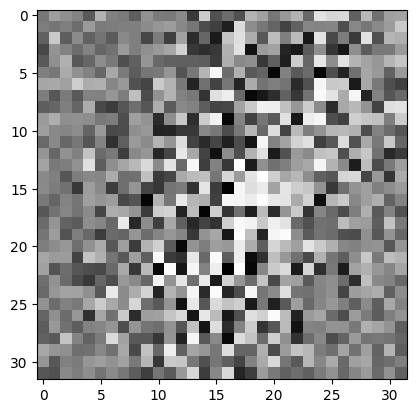

Epoch [1/200], Step [0/50], G_loss: 29.2256, G_identity: 8.8416, G_GAN: 2.7204, G_cycle: 17.6637, D_A_loss: 0.7089, D_B_loss: 0.5810


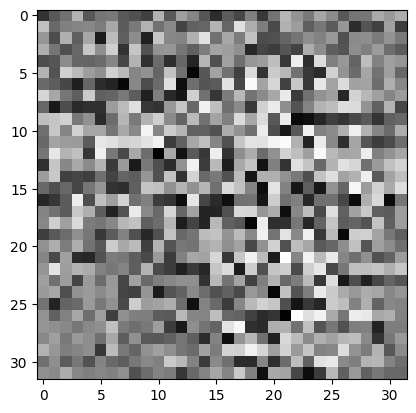

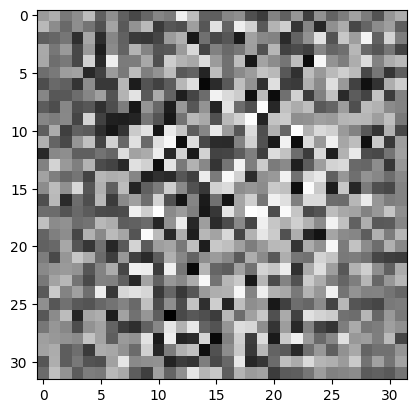

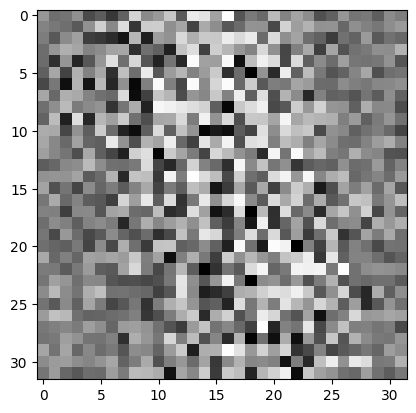

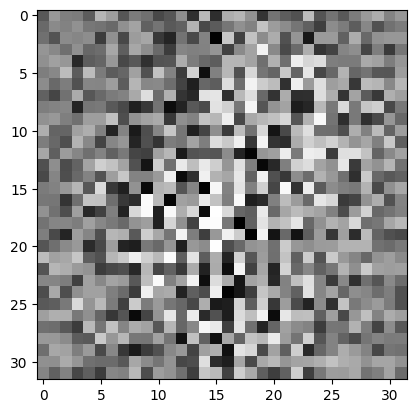

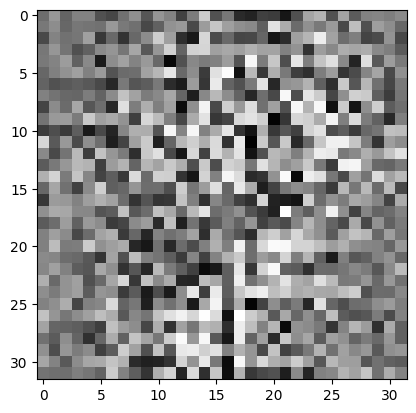

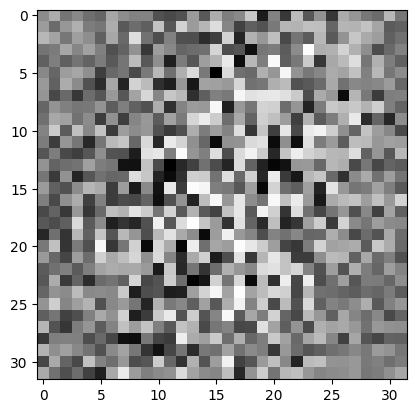

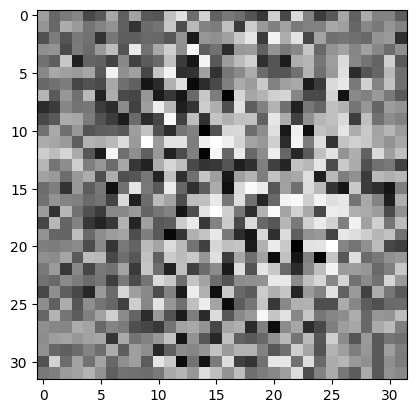

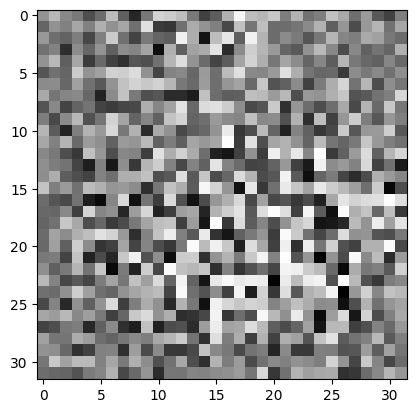

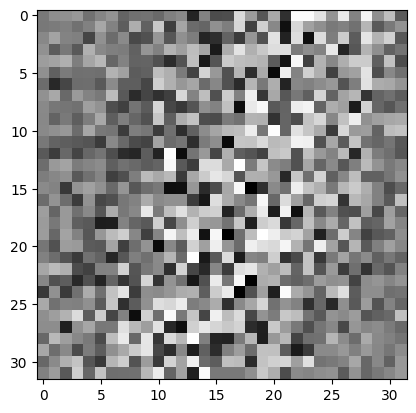

Saving models with cycle loss: 9.5223


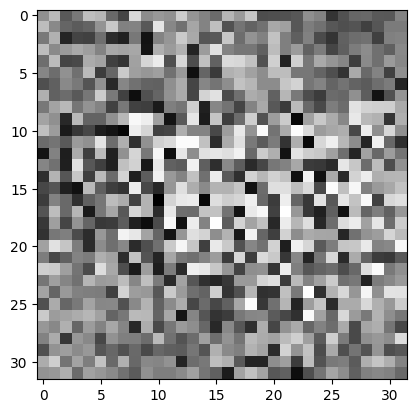

Epoch [2/200], Step [0/50], G_loss: 13.6800, G_identity: 4.0915, G_GAN: 1.3041, G_cycle: 8.2844, D_A_loss: 0.8021, D_B_loss: 0.5315


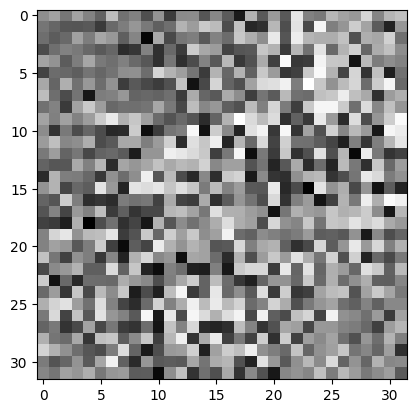

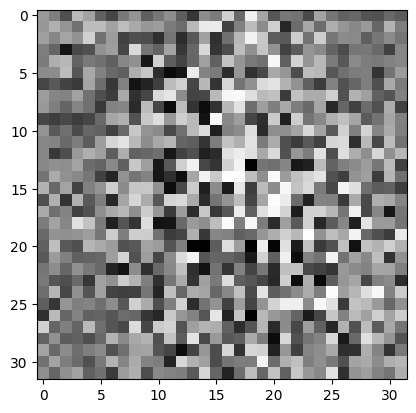

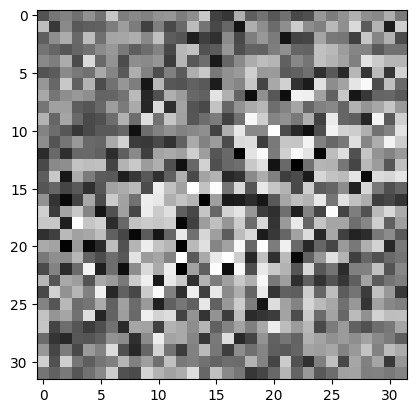

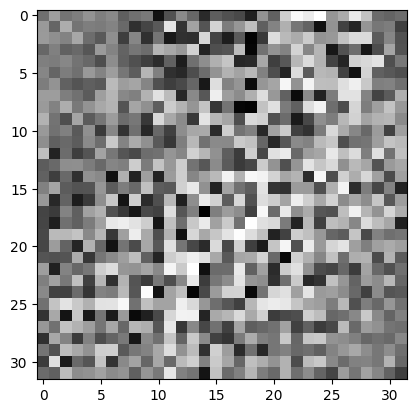

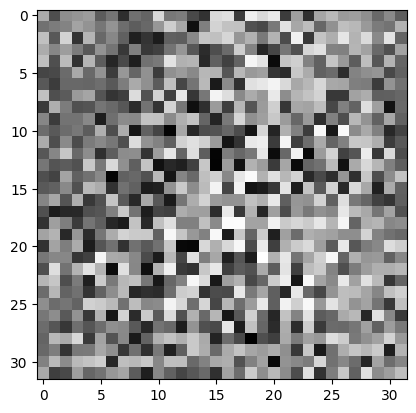

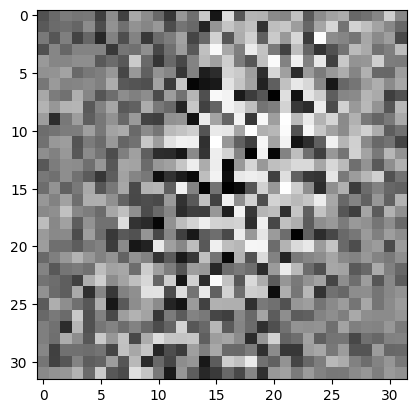

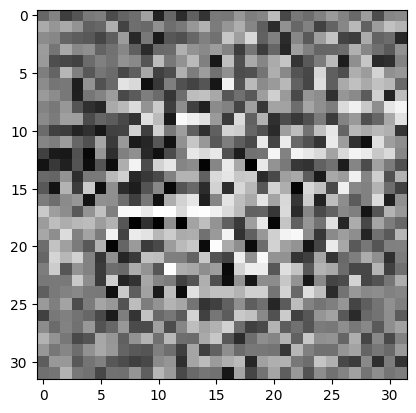

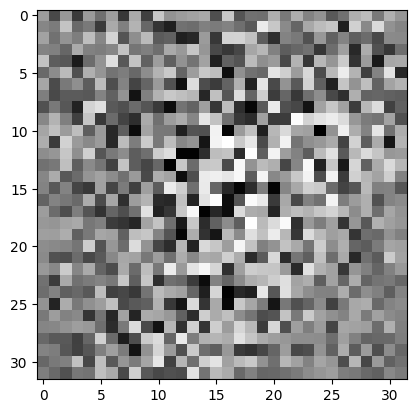

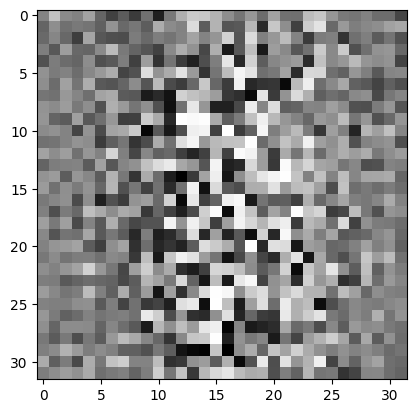

Saving models with cycle loss: 8.4542


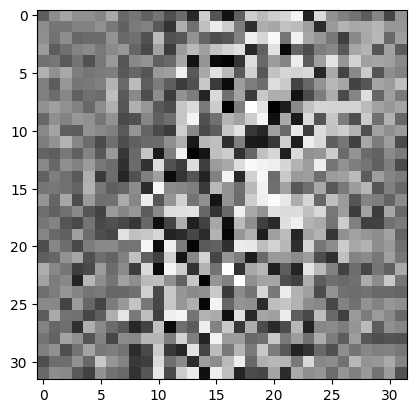

Epoch [3/200], Step [0/50], G_loss: 13.5143, G_identity: 4.1149, G_GAN: 1.1950, G_cycle: 8.2045, D_A_loss: 0.9111, D_B_loss: 0.4963


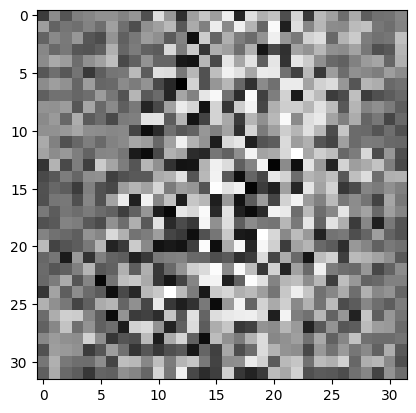

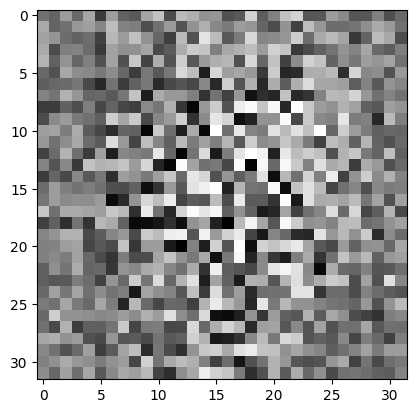

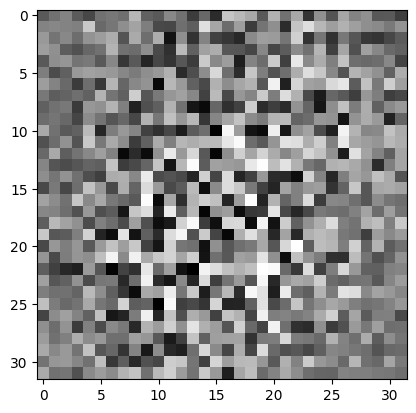

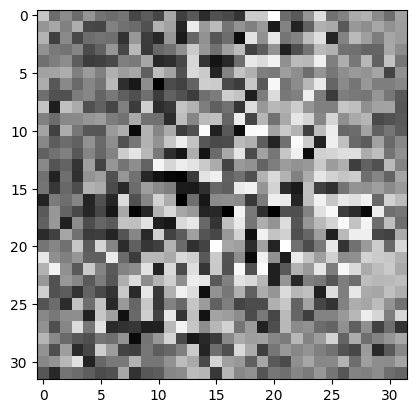

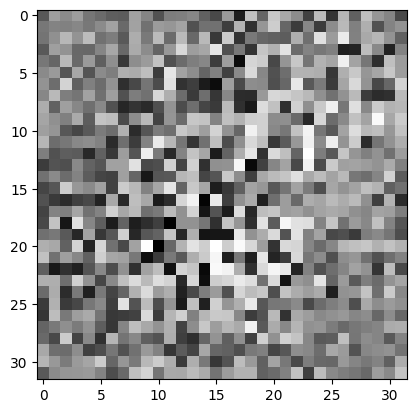

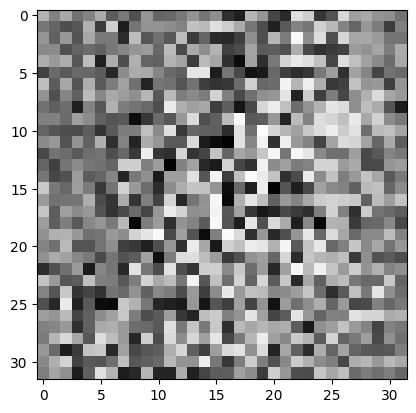

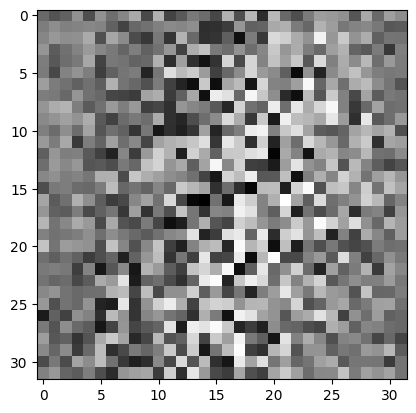

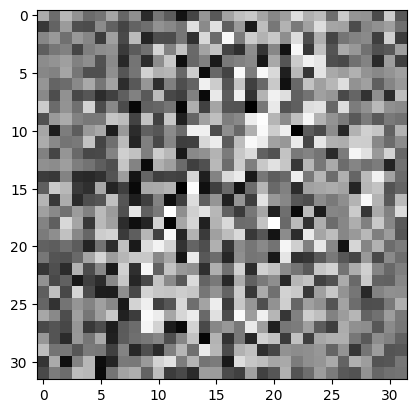

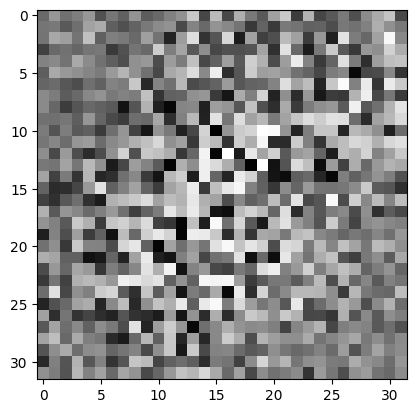

Saving models with cycle loss: 8.1836


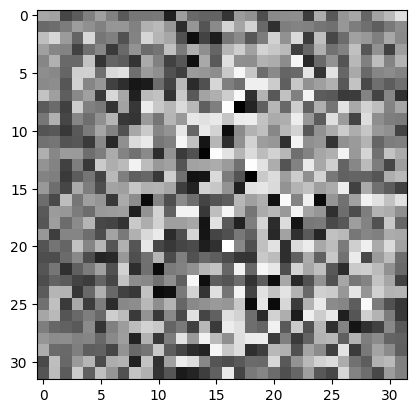

Epoch [4/200], Step [0/50], G_loss: 13.0993, G_identity: 4.0264, G_GAN: 1.0943, G_cycle: 7.9786, D_A_loss: 0.9368, D_B_loss: 0.4567


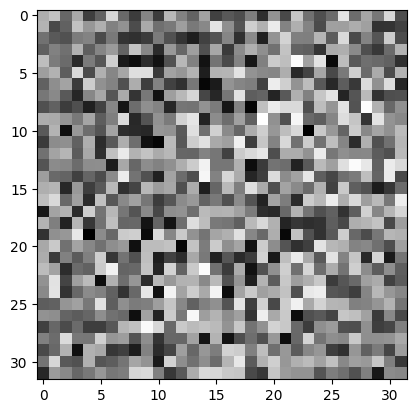

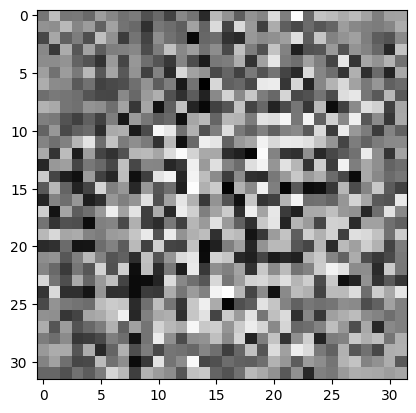

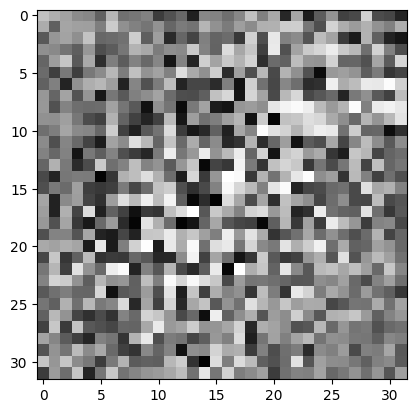

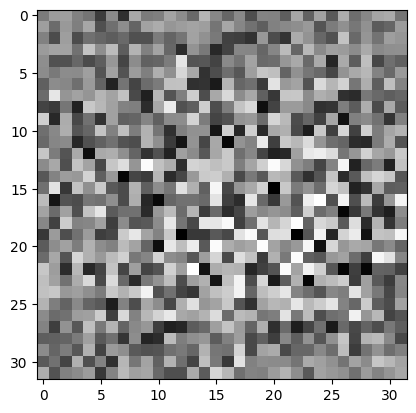

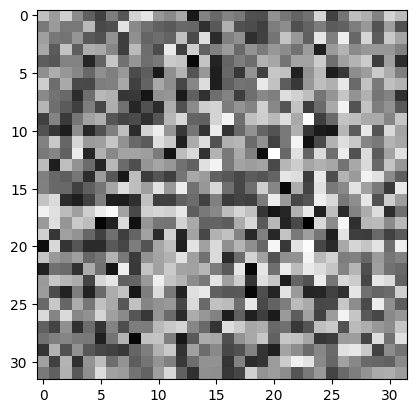

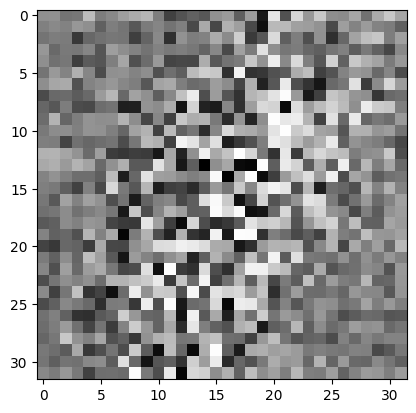

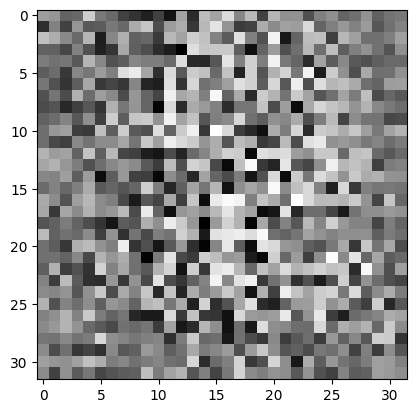

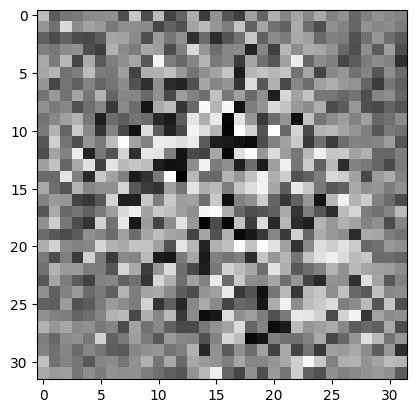

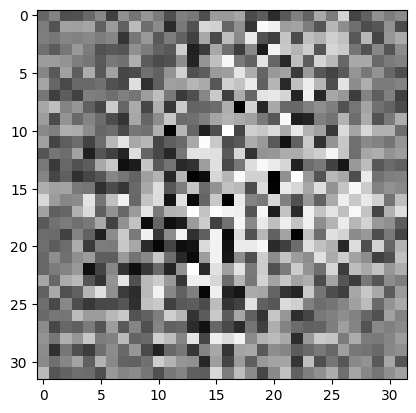

Saving models with cycle loss: 8.0635


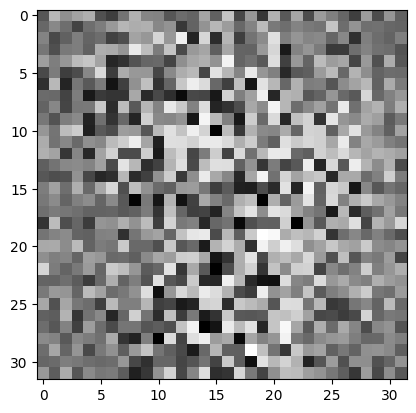

Epoch [5/200], Step [0/50], G_loss: 12.7971, G_identity: 4.0005, G_GAN: 1.0318, G_cycle: 7.7649, D_A_loss: 0.9252, D_B_loss: 0.4483


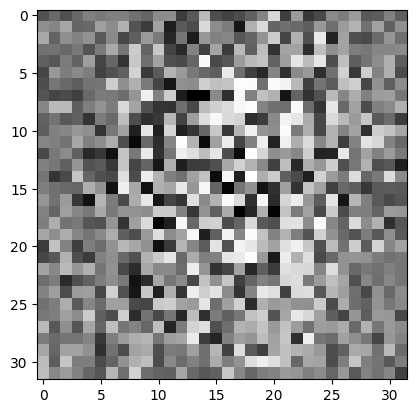

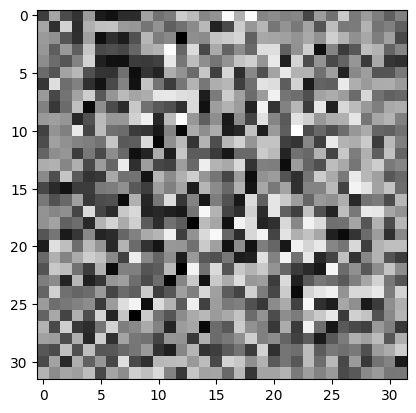

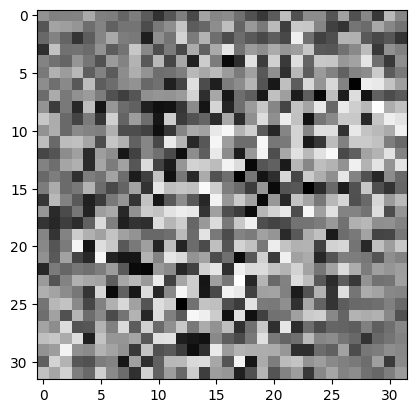

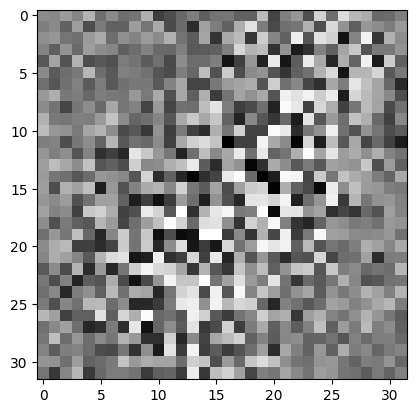

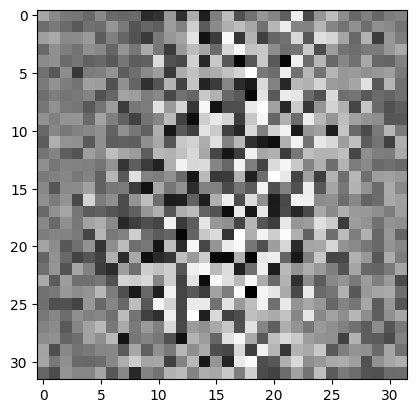

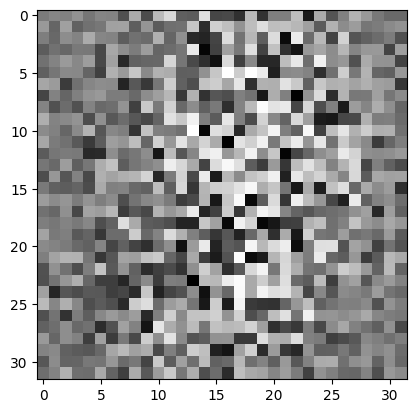

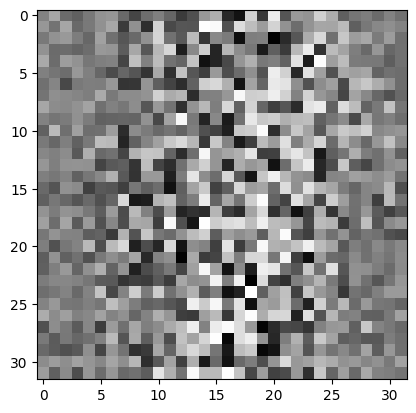

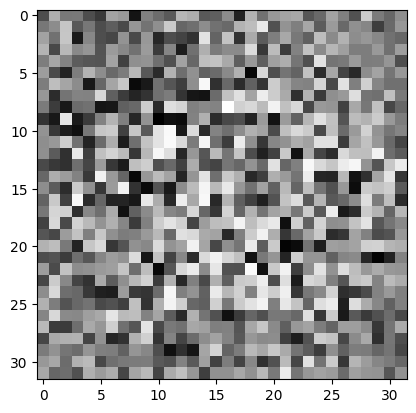

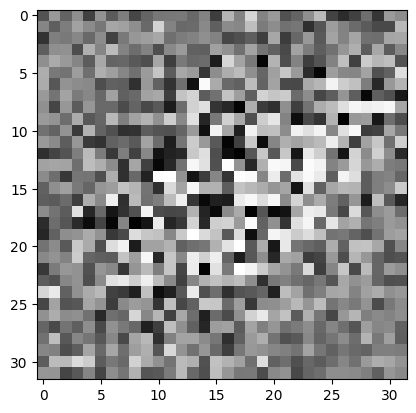

Saving models with cycle loss: 7.9251


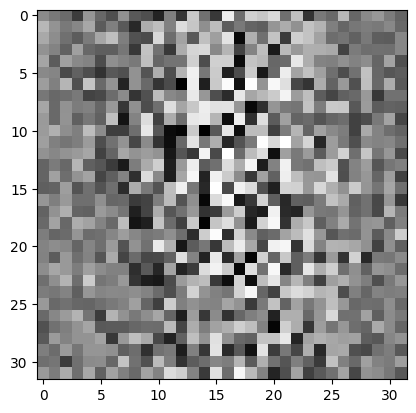

Epoch [6/200], Step [0/50], G_loss: 12.9378, G_identity: 4.0694, G_GAN: 0.9535, G_cycle: 7.9149, D_A_loss: 0.9465, D_B_loss: 0.4090


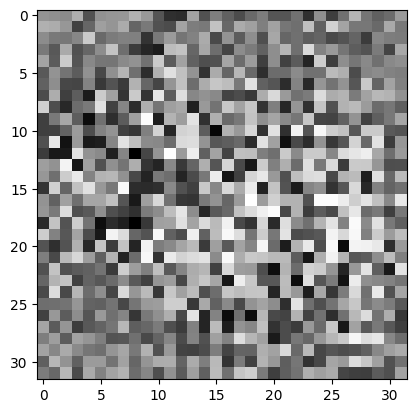

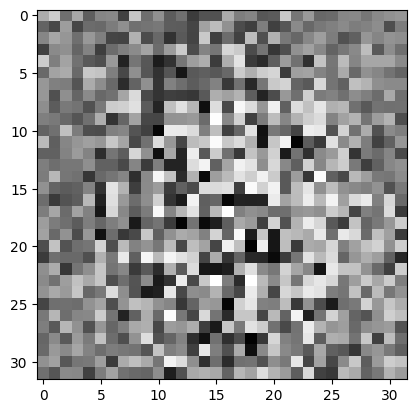

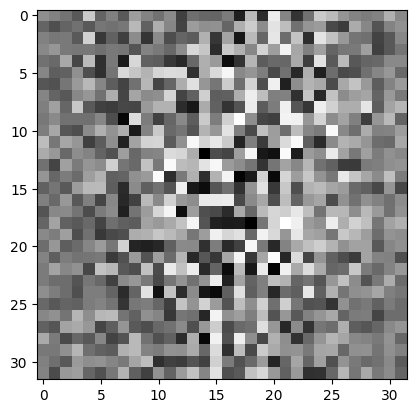

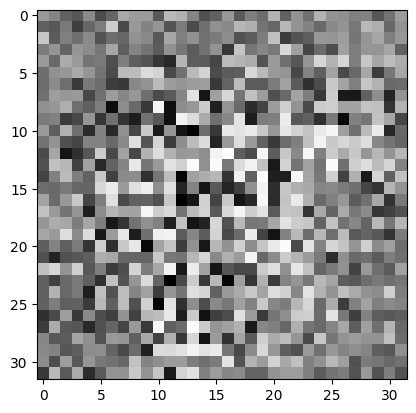

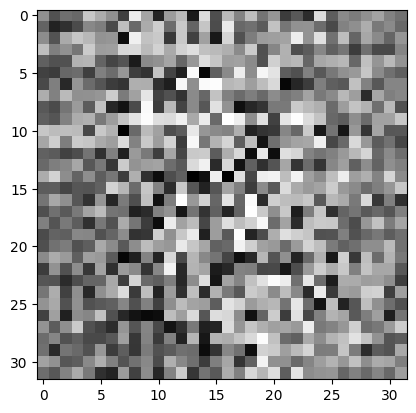

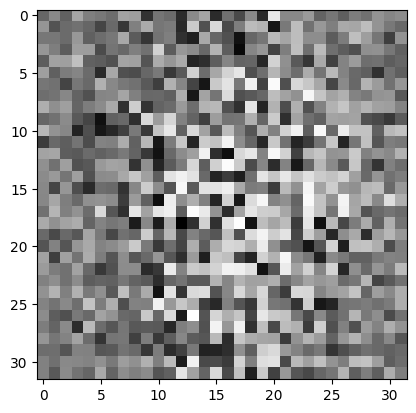

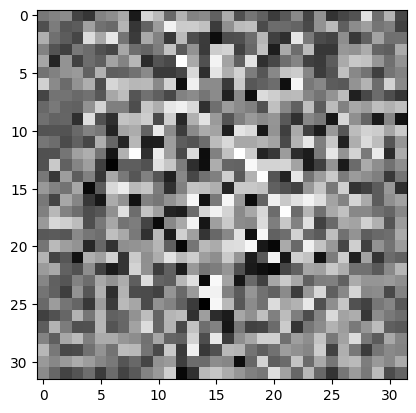

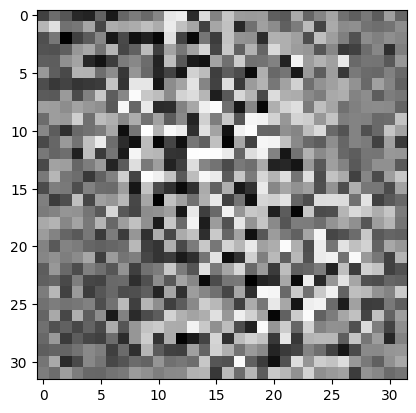

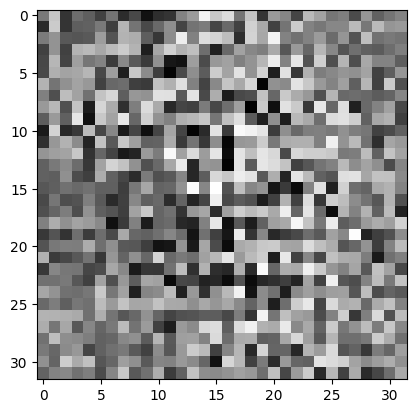

Saving models with cycle loss: 7.8244


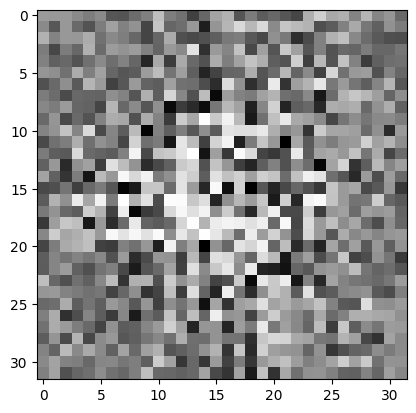

Epoch [7/200], Step [0/50], G_loss: 12.8856, G_identity: 4.0884, G_GAN: 0.8985, G_cycle: 7.8987, D_A_loss: 0.9717, D_B_loss: 0.3803


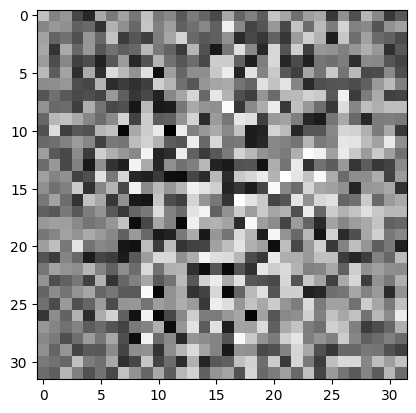

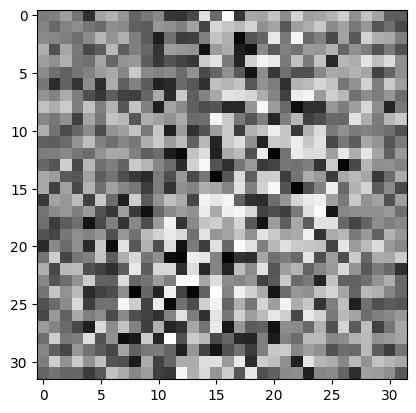

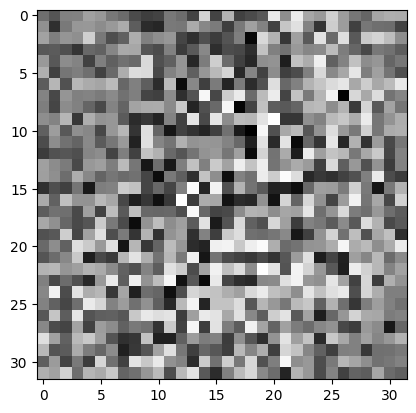

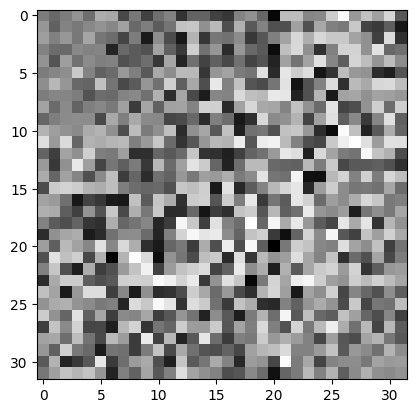

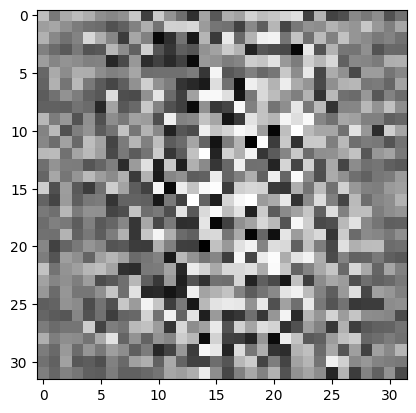

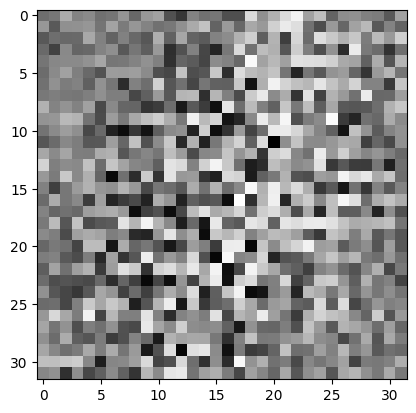

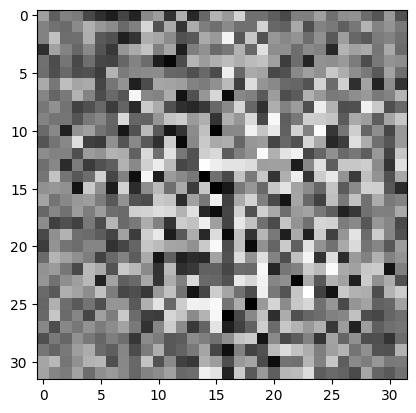

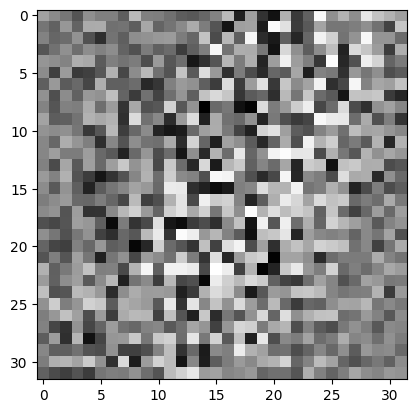

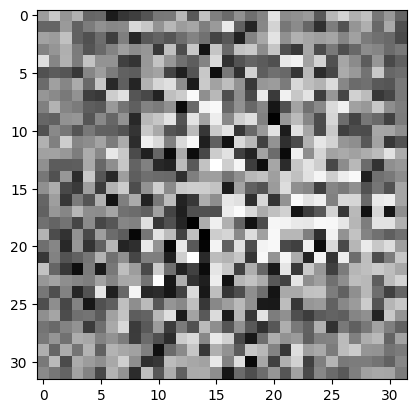

Saving models with cycle loss: 7.7552


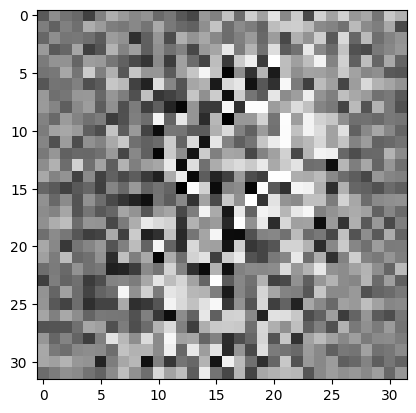

Epoch [8/200], Step [0/50], G_loss: 12.6818, G_identity: 4.0576, G_GAN: 0.8728, G_cycle: 7.7515, D_A_loss: 0.9575, D_B_loss: 0.3515


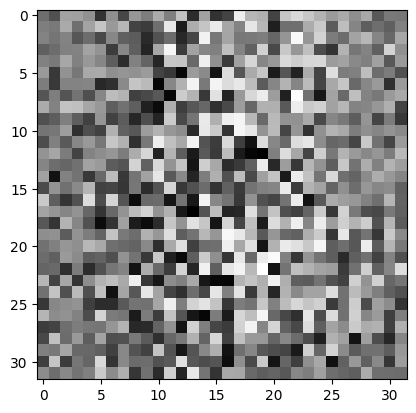

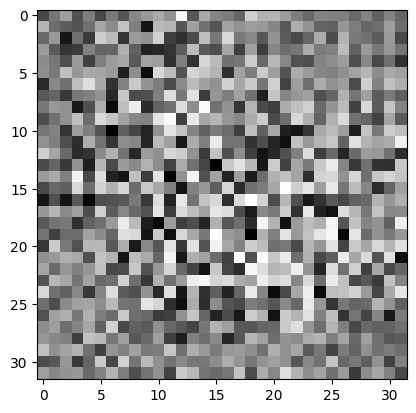

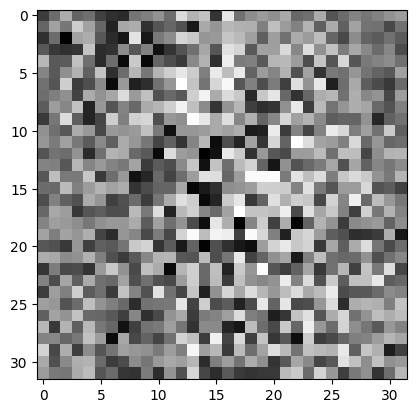

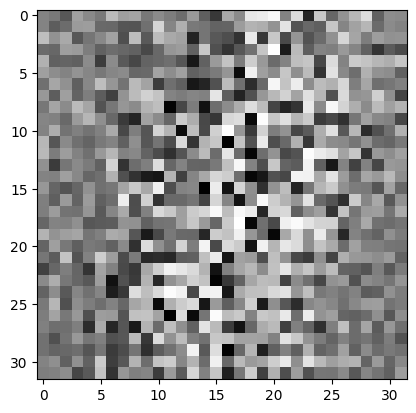

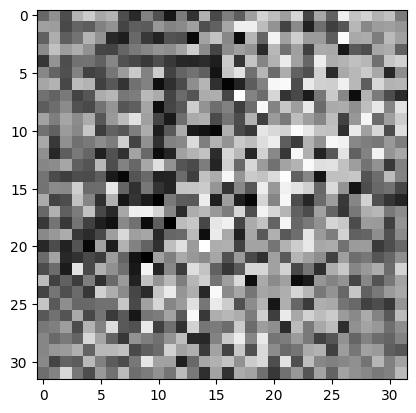

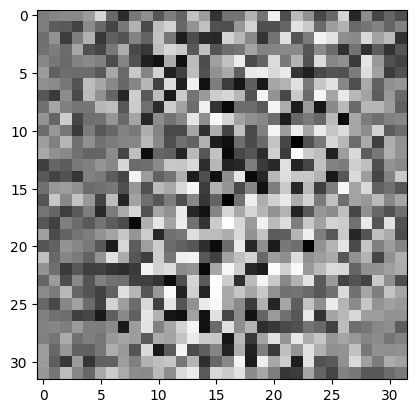

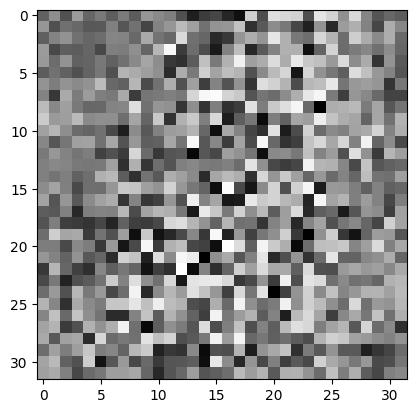

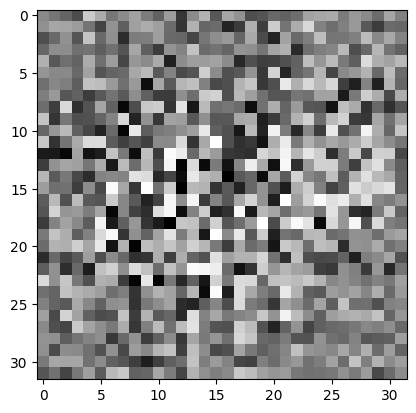

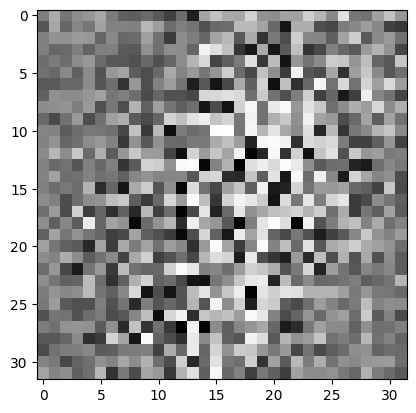

Saving models with cycle loss: 7.6985


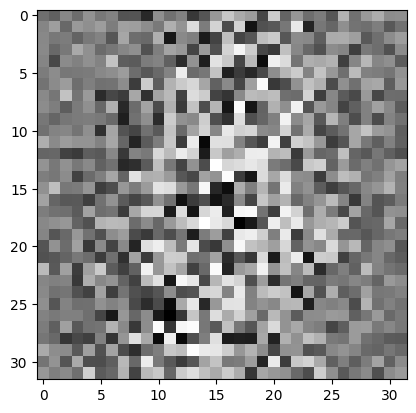

Epoch [9/200], Step [0/50], G_loss: 12.5938, G_identity: 4.0111, G_GAN: 0.8733, G_cycle: 7.7093, D_A_loss: 0.9647, D_B_loss: 0.3579


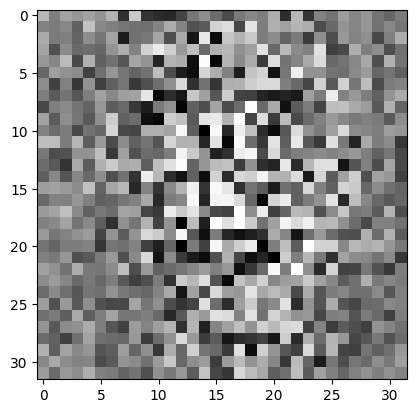

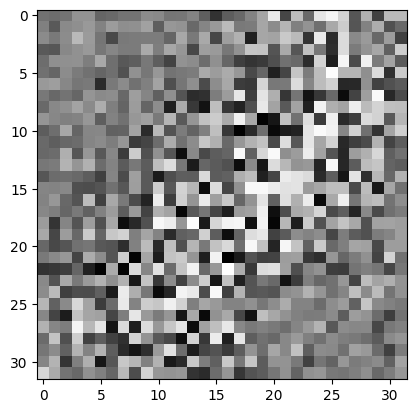

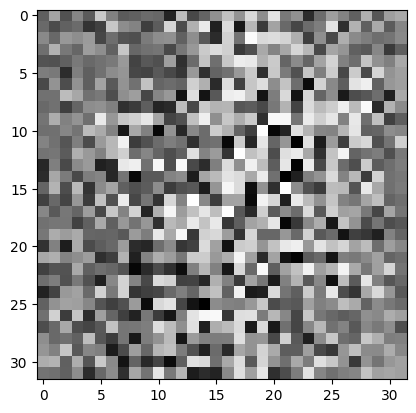

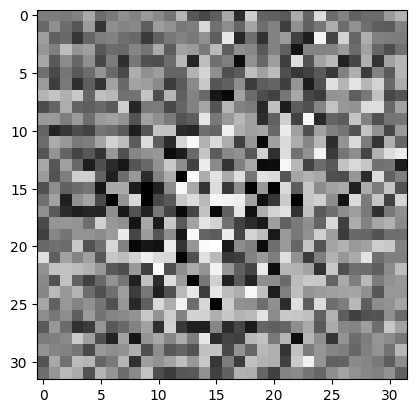

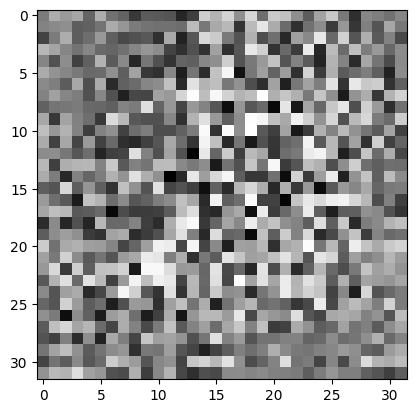

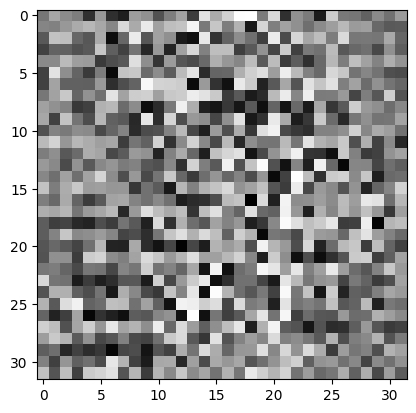

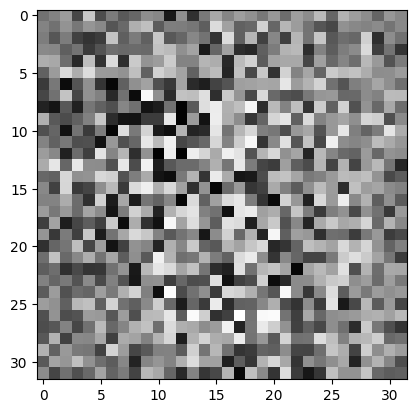

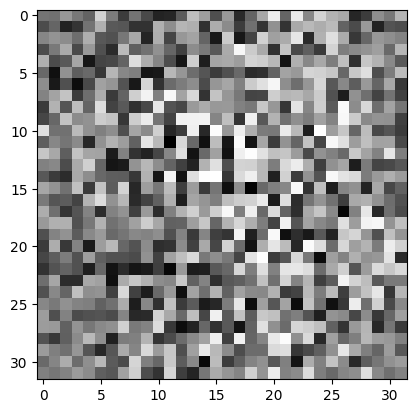

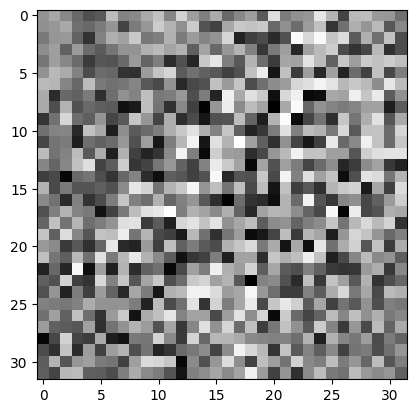

Saving models with cycle loss: 7.6535


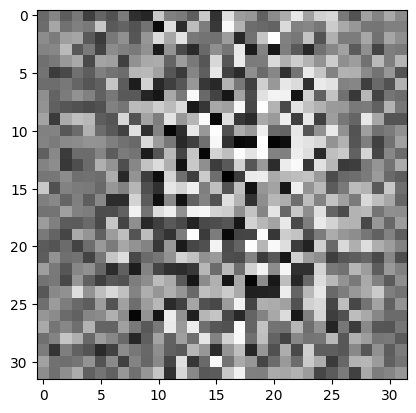

Epoch [10/200], Step [0/50], G_loss: 12.5281, G_identity: 4.0047, G_GAN: 0.8176, G_cycle: 7.7057, D_A_loss: 0.9116, D_B_loss: 0.3253


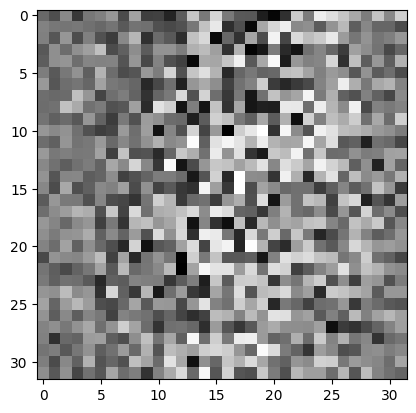

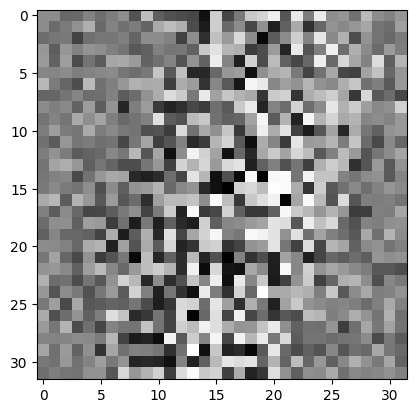

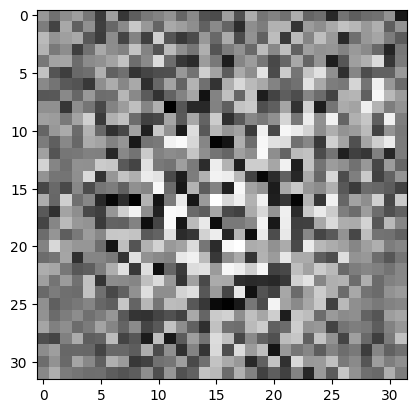

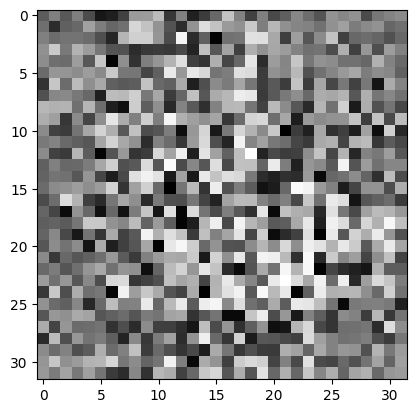

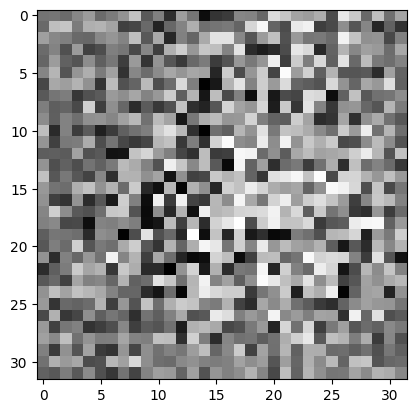

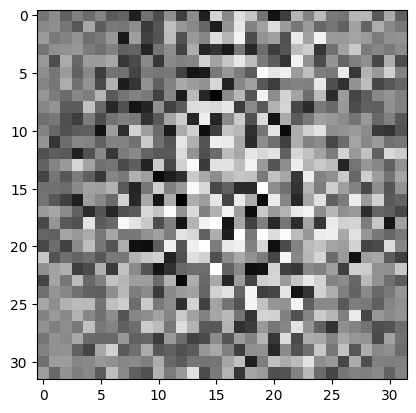

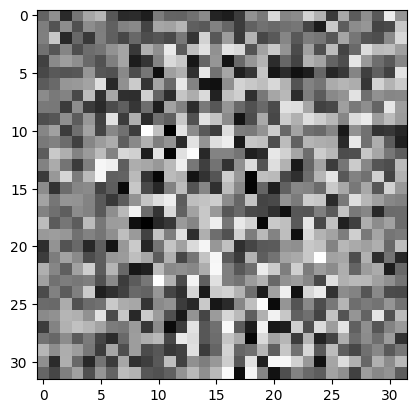

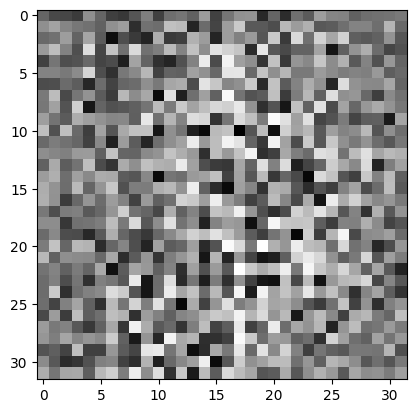

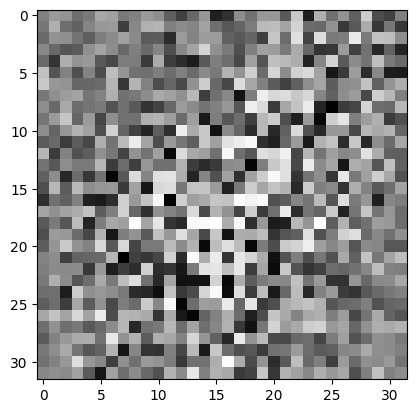

Saving models with cycle loss: 7.6129


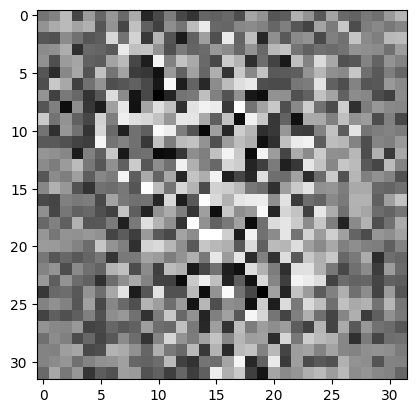

Epoch [11/200], Step [0/50], G_loss: 13.0539, G_identity: 4.0564, G_GAN: 0.9414, G_cycle: 8.0561, D_A_loss: 0.8308, D_B_loss: 0.3088


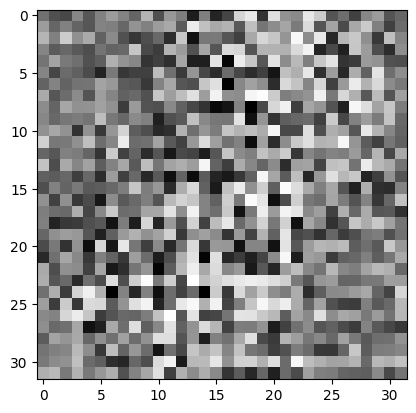

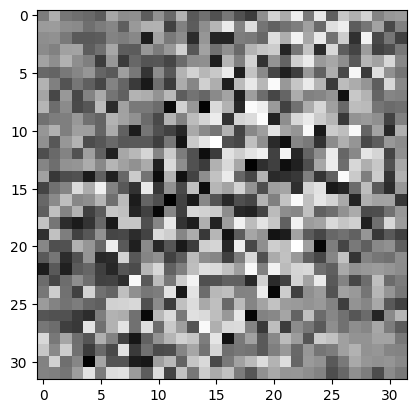

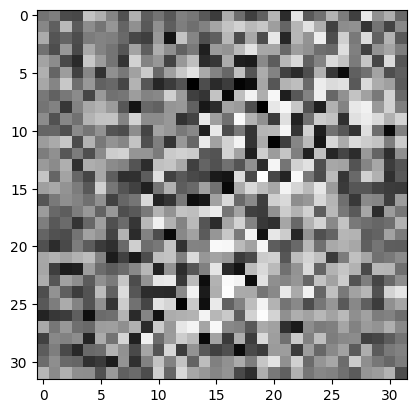

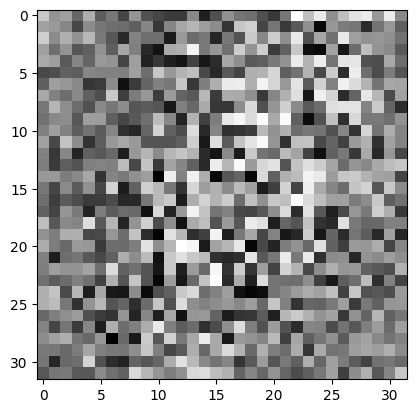

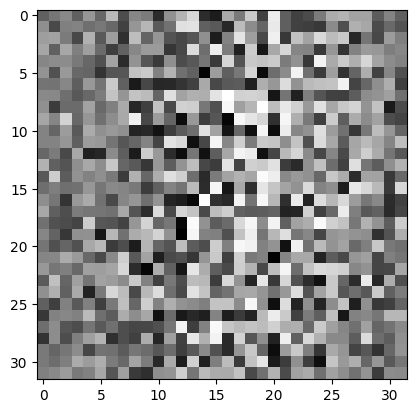

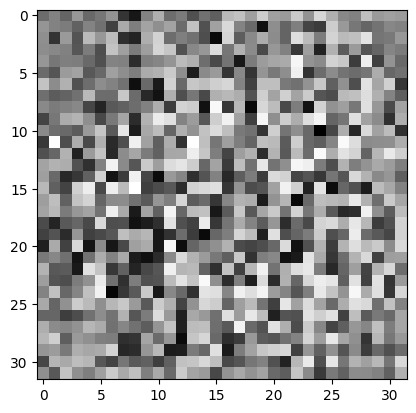

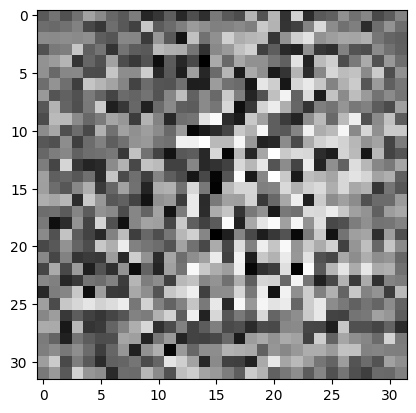

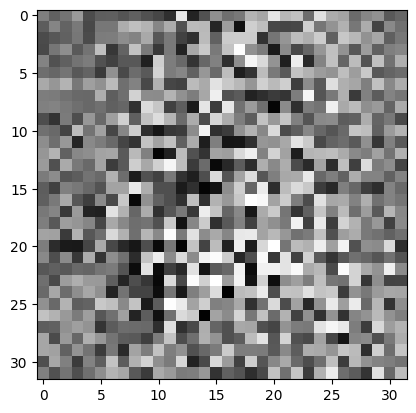

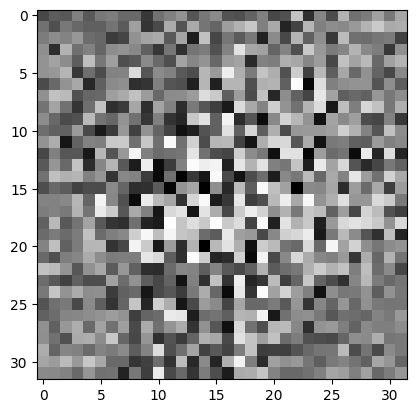

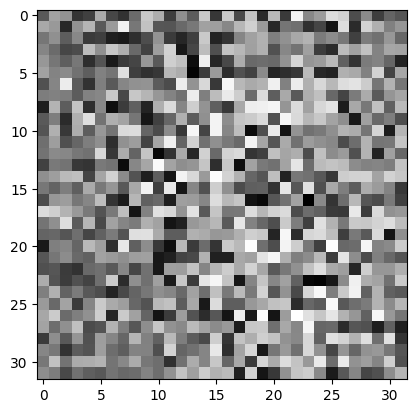

Epoch [12/200], Step [0/50], G_loss: 12.2862, G_identity: 3.9624, G_GAN: 0.7255, G_cycle: 7.5982, D_A_loss: 0.9482, D_B_loss: 0.3107


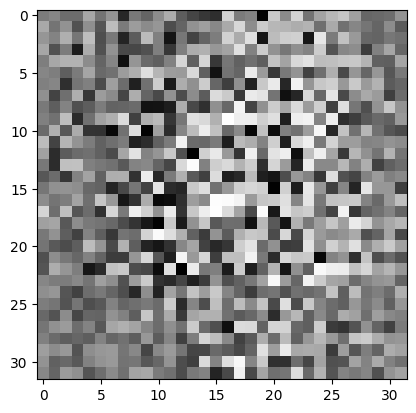

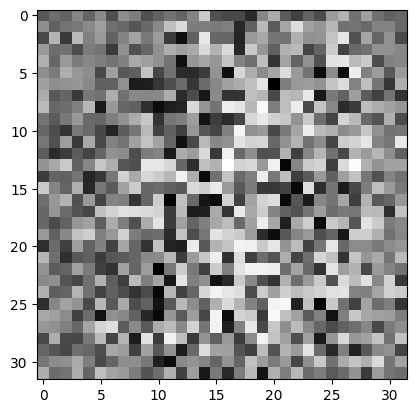

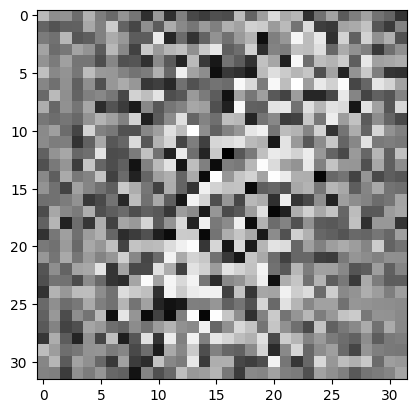

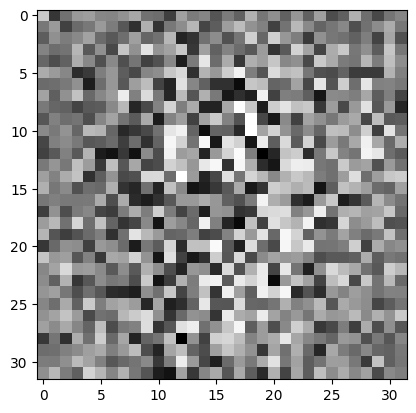

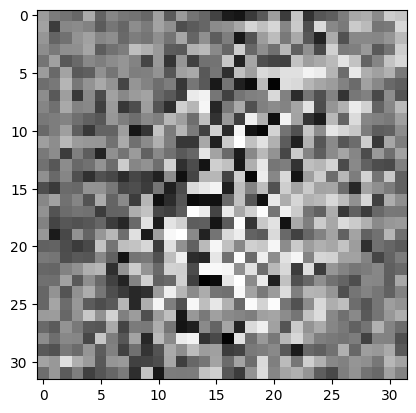

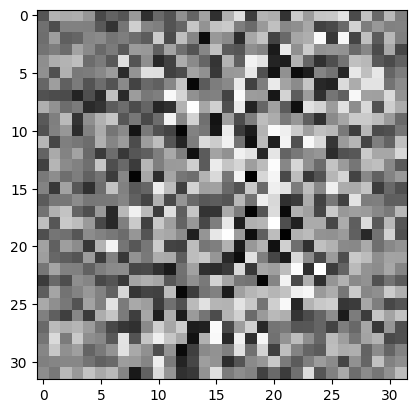

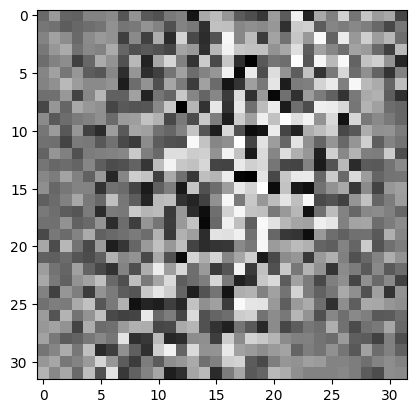

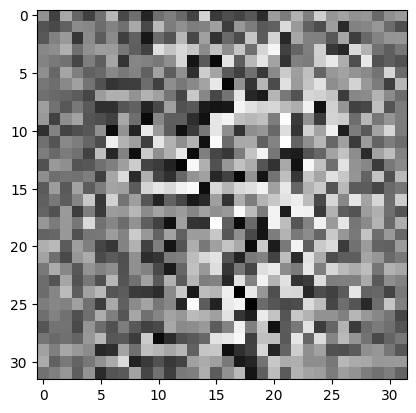

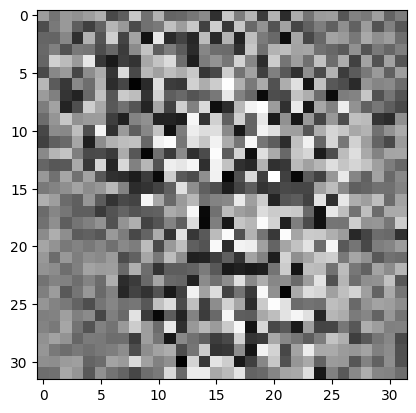

Saving models with cycle loss: 7.6075


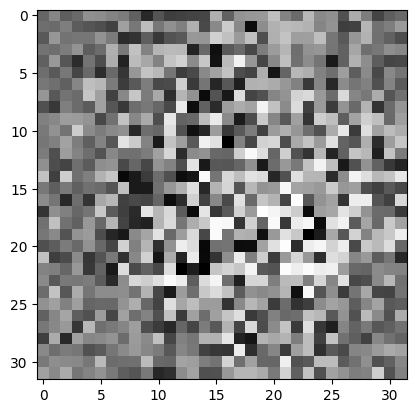

Epoch [13/200], Step [0/50], G_loss: 12.1536, G_identity: 3.9457, G_GAN: 0.6898, G_cycle: 7.5181, D_A_loss: 0.9146, D_B_loss: 0.3031


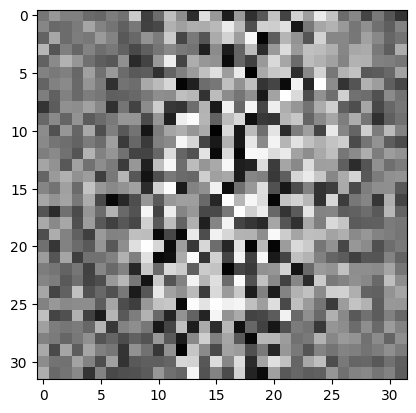

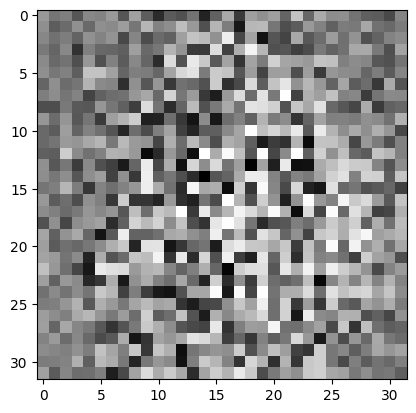

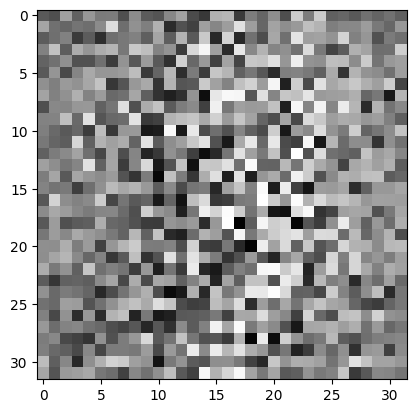

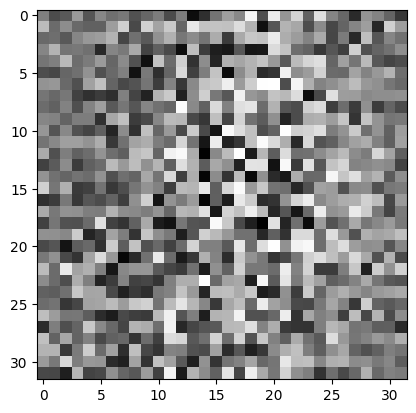

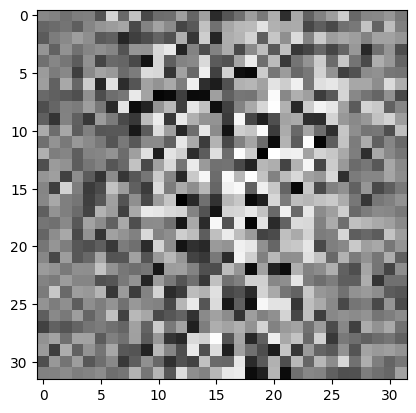

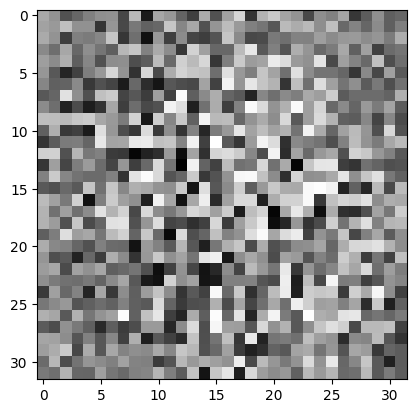

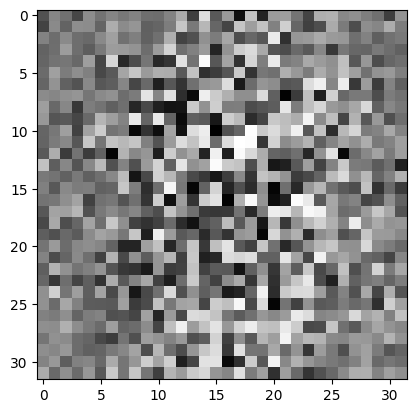

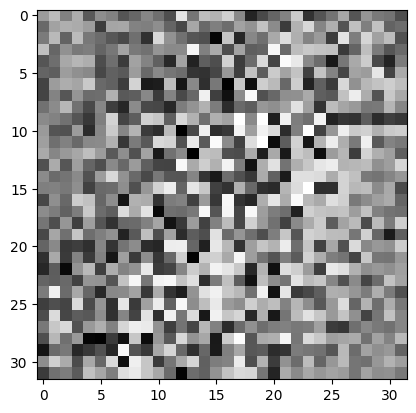

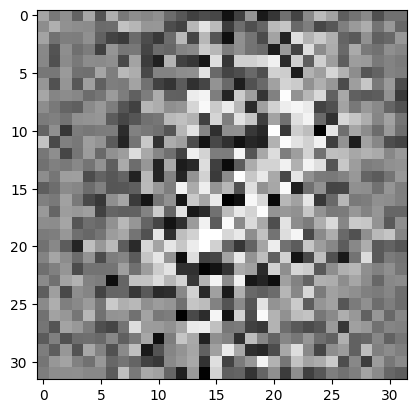

Saving models with cycle loss: 7.5301


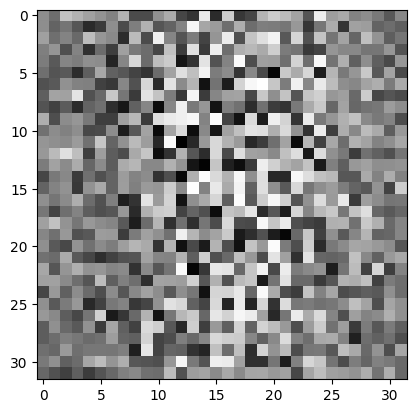

Epoch [14/200], Step [0/50], G_loss: 11.7345, G_identity: 3.8215, G_GAN: 0.7049, G_cycle: 7.2081, D_A_loss: 0.9286, D_B_loss: 0.2949


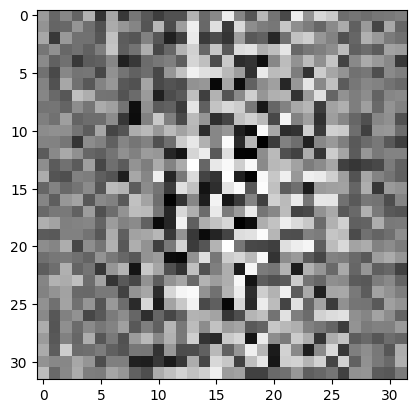

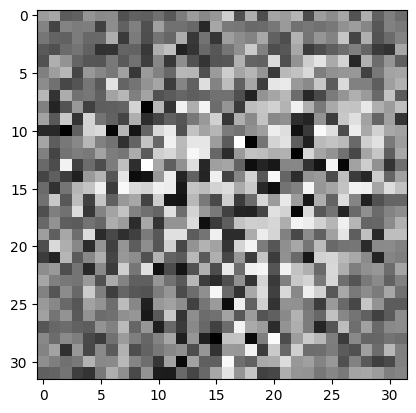

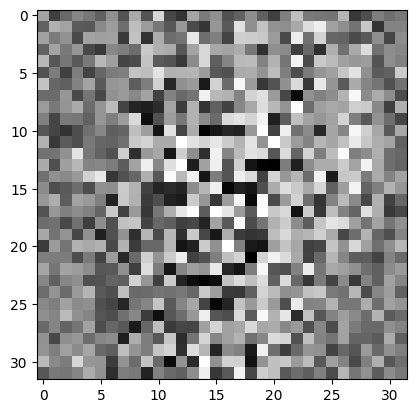

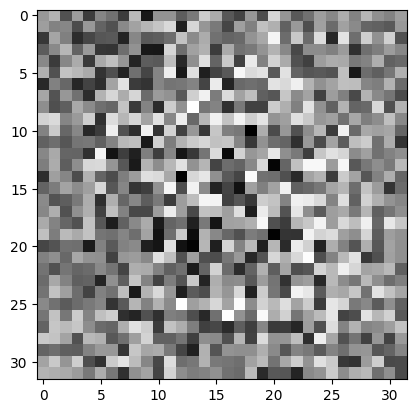

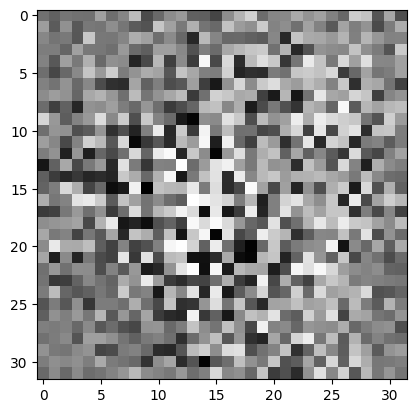

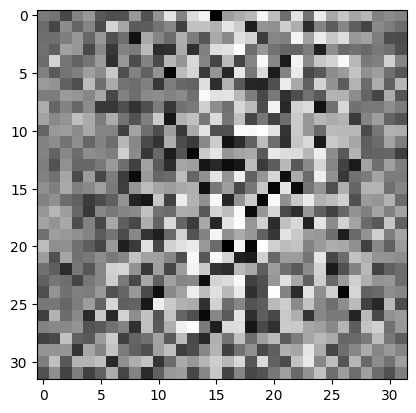

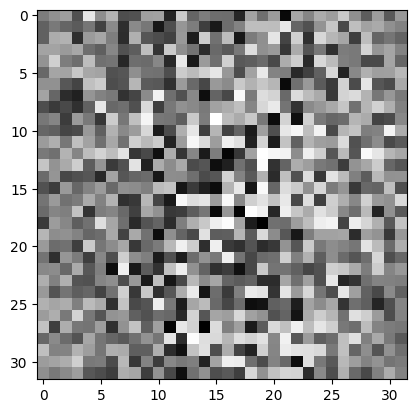

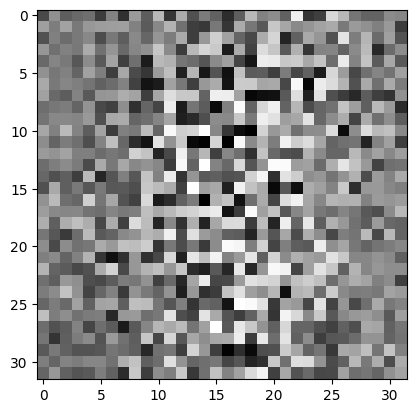

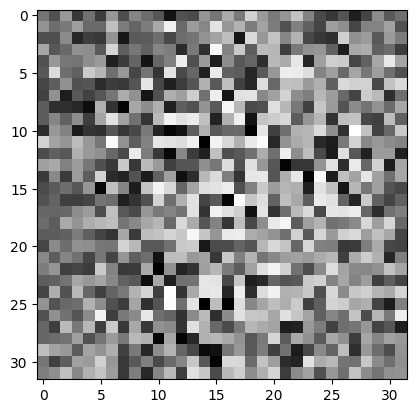

Saving models with cycle loss: 7.5062


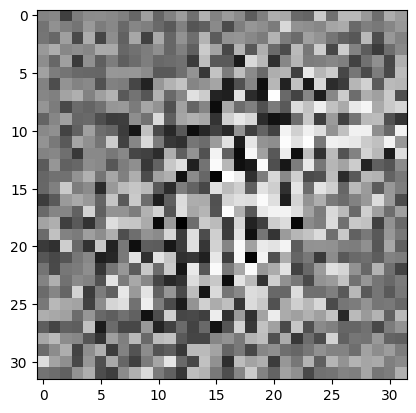

Epoch [15/200], Step [0/50], G_loss: 12.3955, G_identity: 4.0648, G_GAN: 0.6897, G_cycle: 7.6410, D_A_loss: 0.9292, D_B_loss: 0.2582


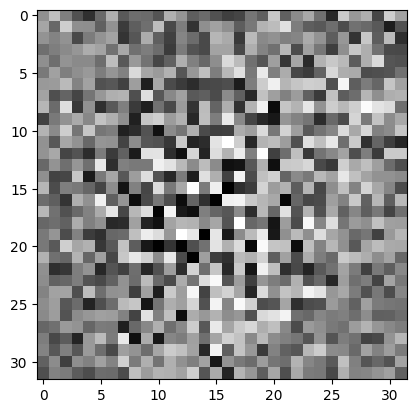

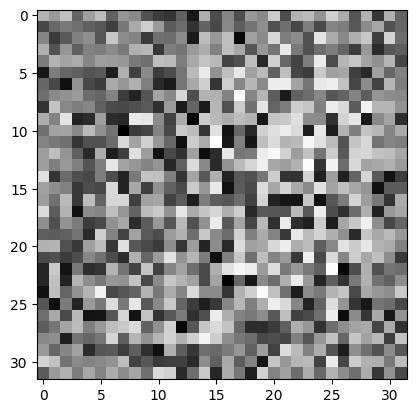

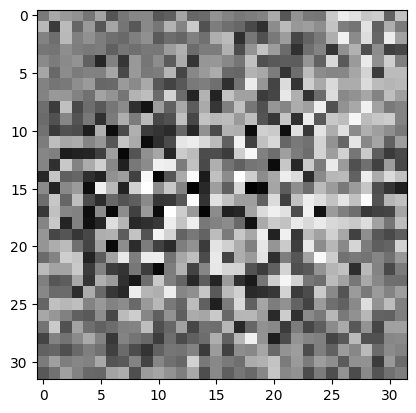

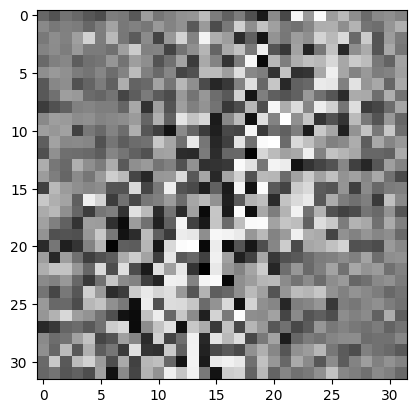

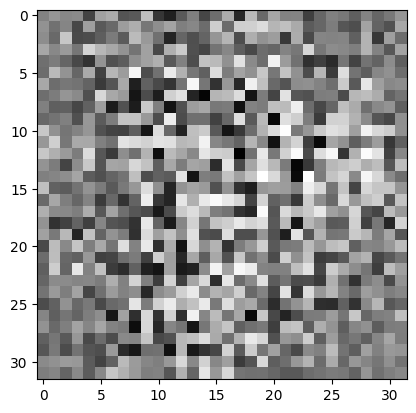

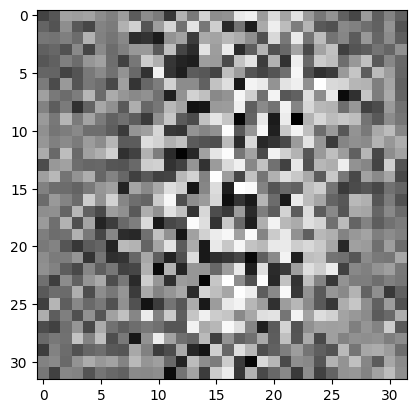

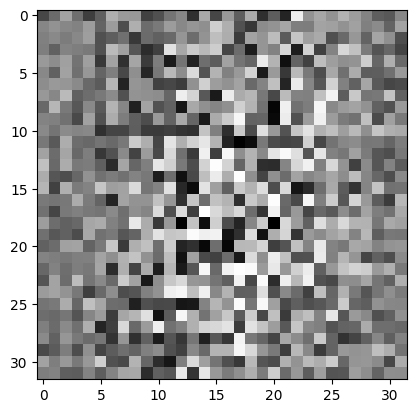

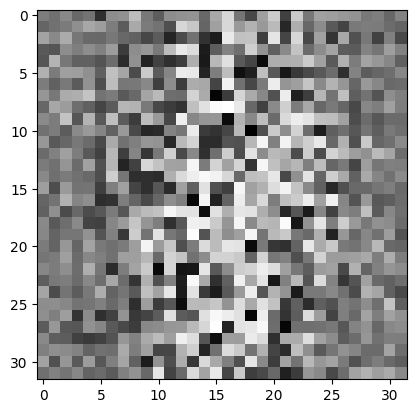

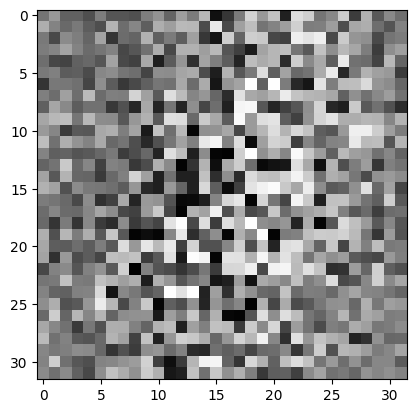

Saving models with cycle loss: 7.4917


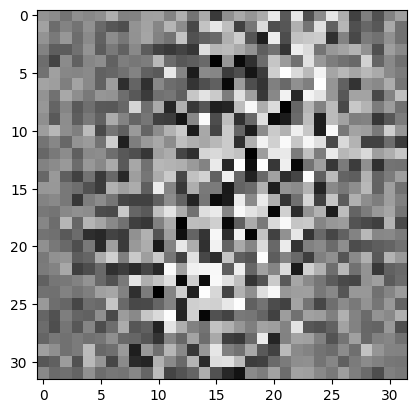

Epoch [16/200], Step [0/50], G_loss: 11.9758, G_identity: 3.9335, G_GAN: 0.6957, G_cycle: 7.3465, D_A_loss: 0.9145, D_B_loss: 0.2731


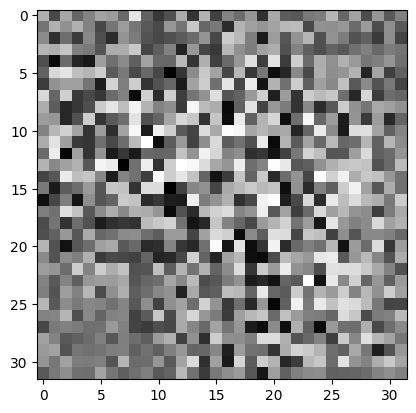

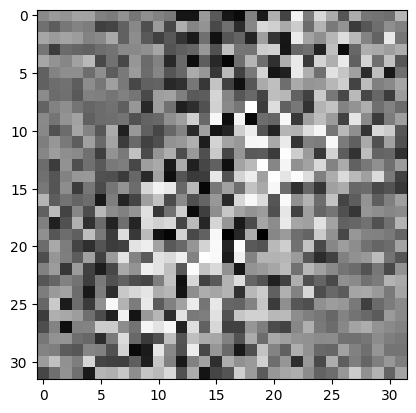

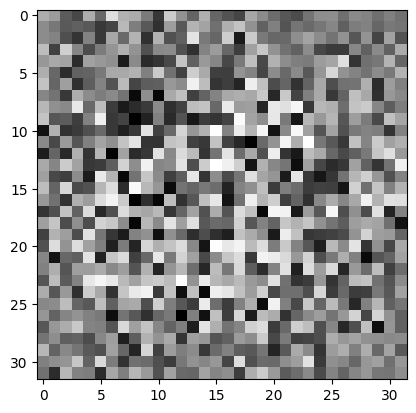

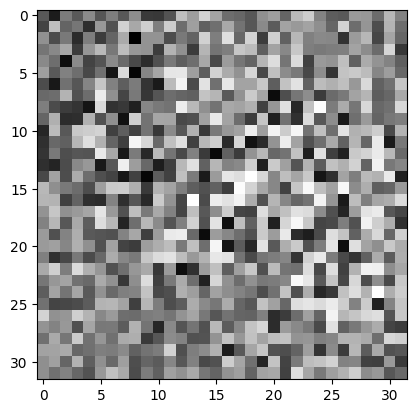

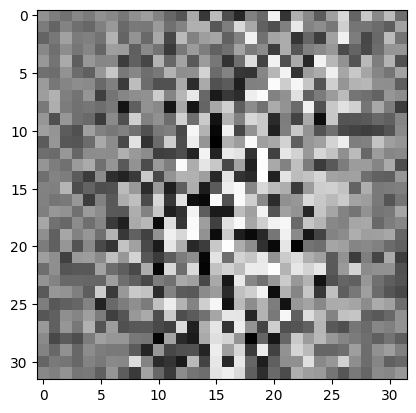

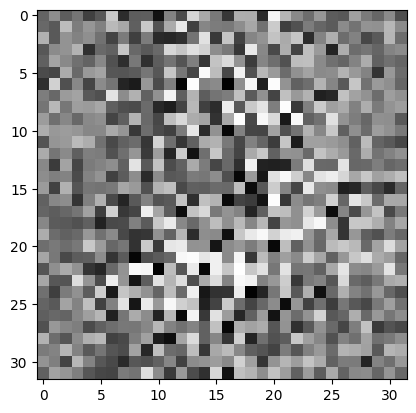

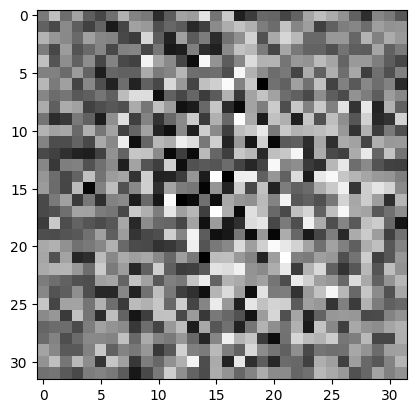

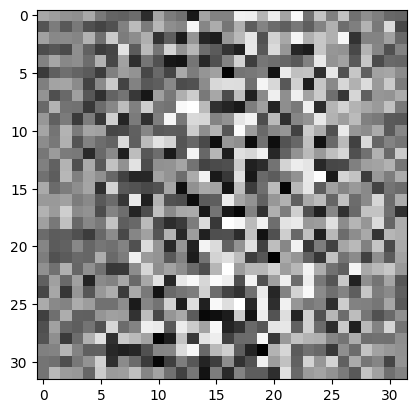

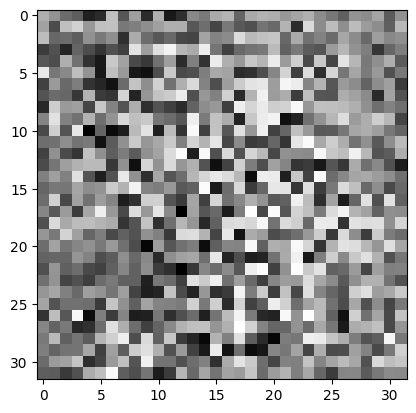

Saving models with cycle loss: 7.4628


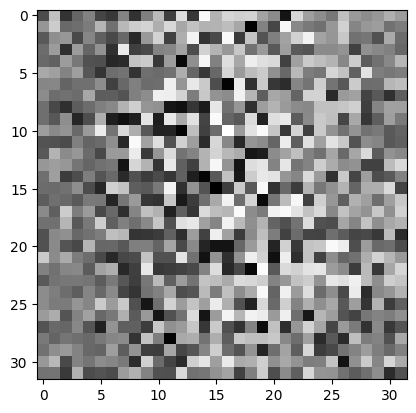

Epoch [17/200], Step [0/50], G_loss: 11.9873, G_identity: 3.9546, G_GAN: 0.6453, G_cycle: 7.3874, D_A_loss: 0.8708, D_B_loss: 0.2724


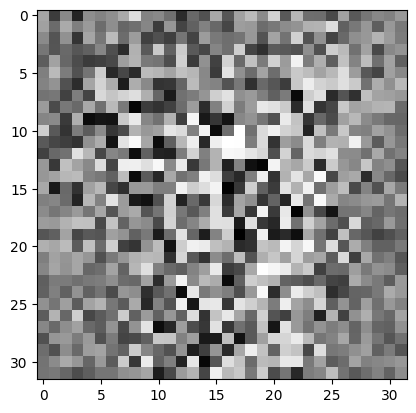

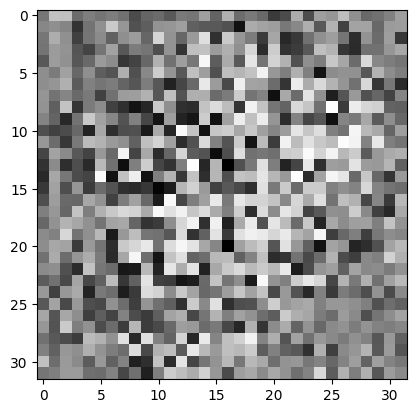

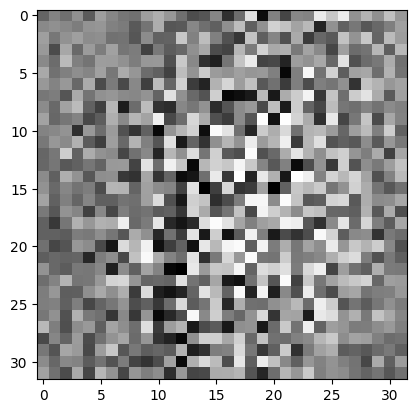

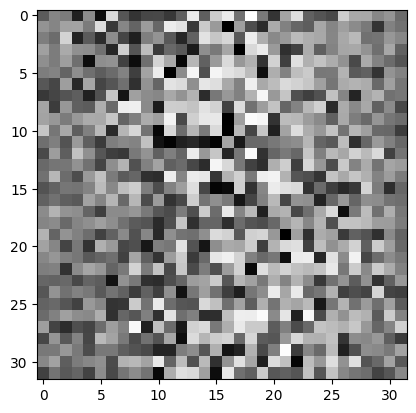

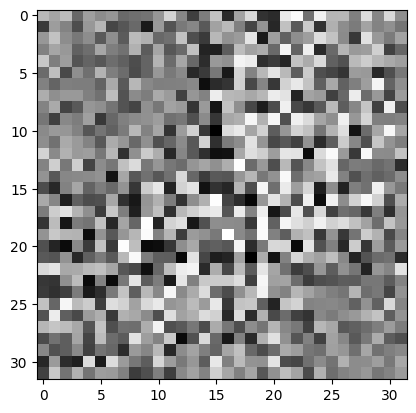

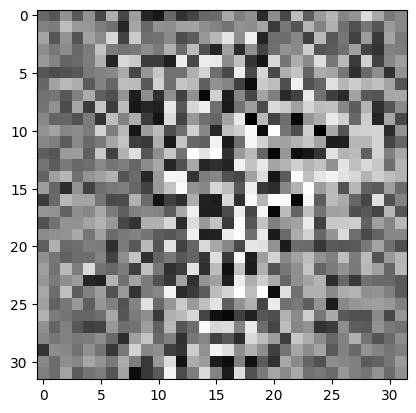

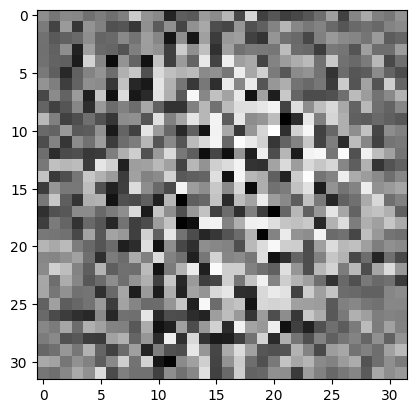

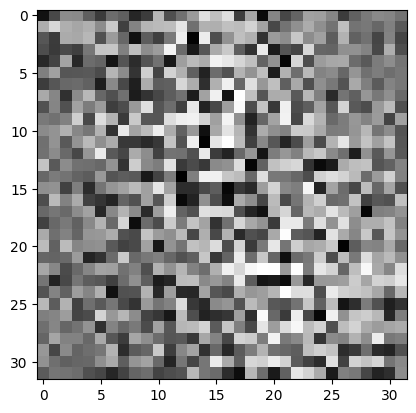

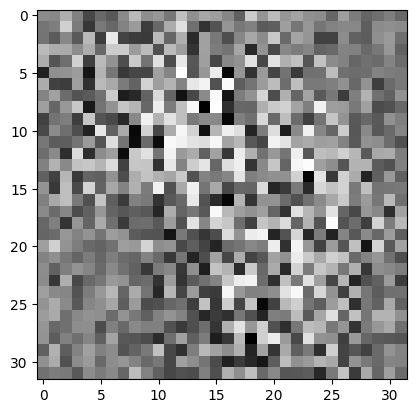

Saving models with cycle loss: 7.4435


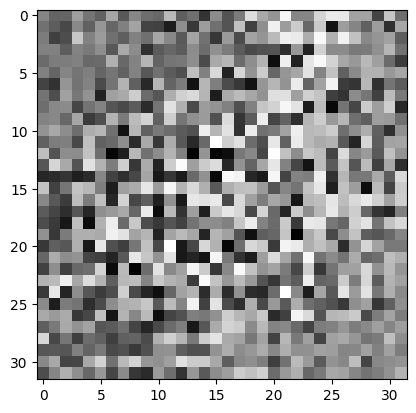

Epoch [18/200], Step [0/50], G_loss: 11.8161, G_identity: 3.8971, G_GAN: 0.5936, G_cycle: 7.3254, D_A_loss: 0.8860, D_B_loss: 0.2527


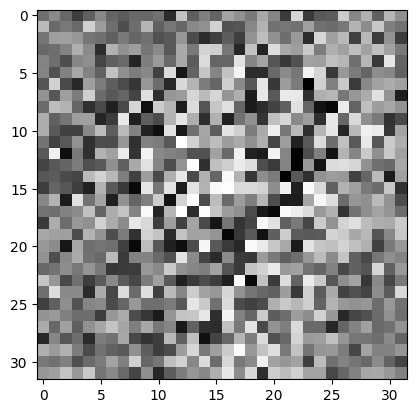

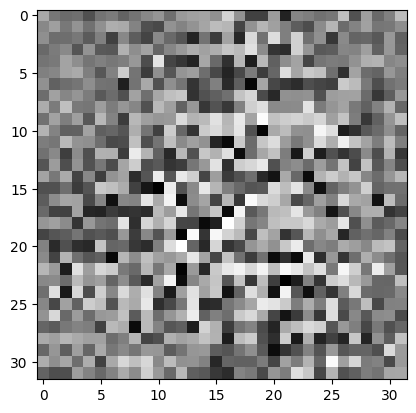

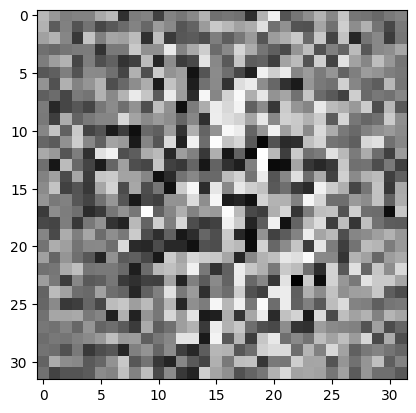

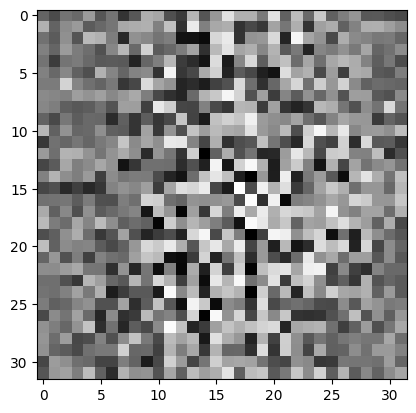

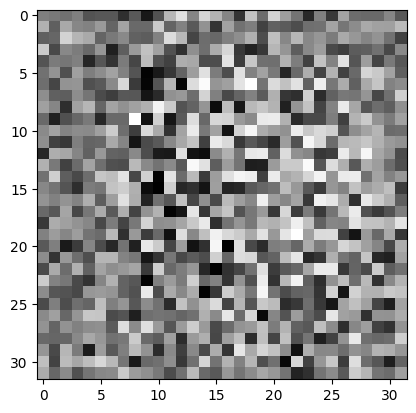

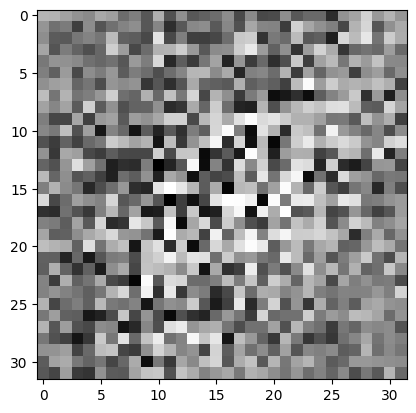

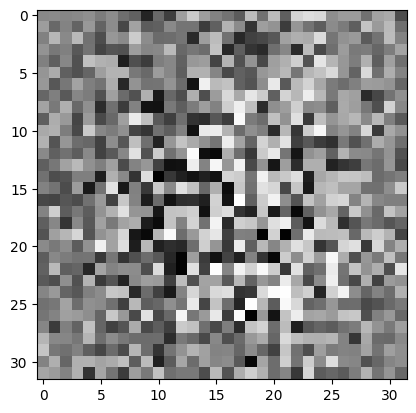

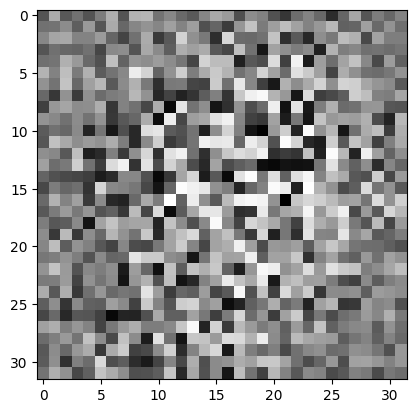

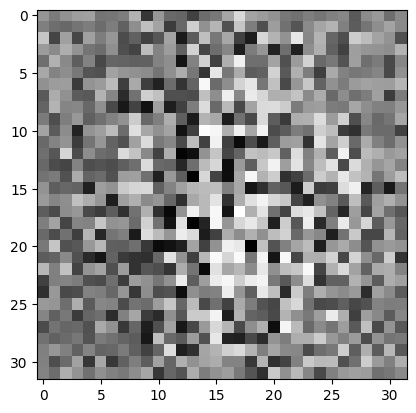

Saving models with cycle loss: 7.4323


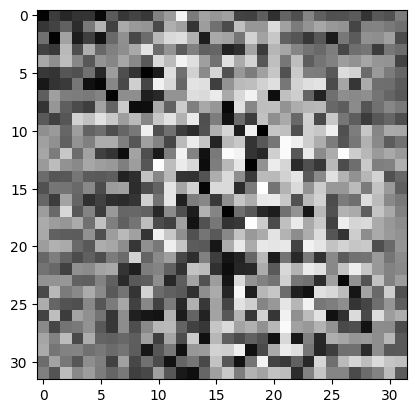

Epoch [19/200], Step [0/50], G_loss: 11.7990, G_identity: 3.9102, G_GAN: 0.5930, G_cycle: 7.2957, D_A_loss: 0.8993, D_B_loss: 0.2417


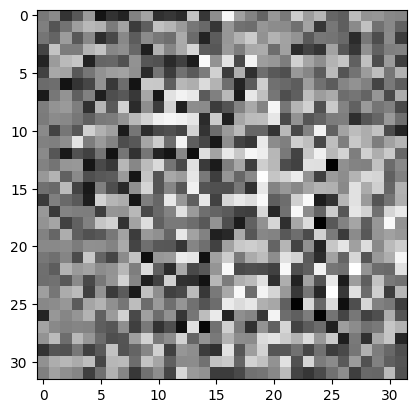

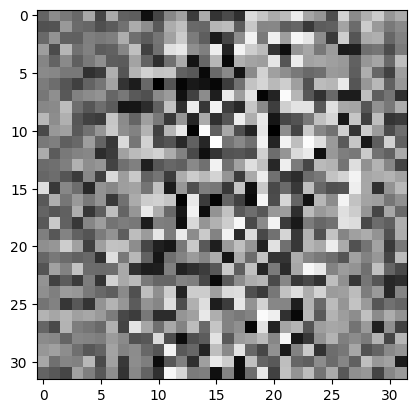

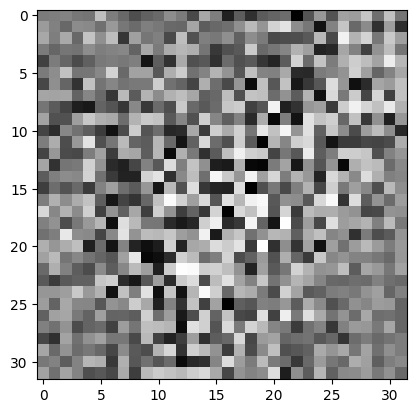

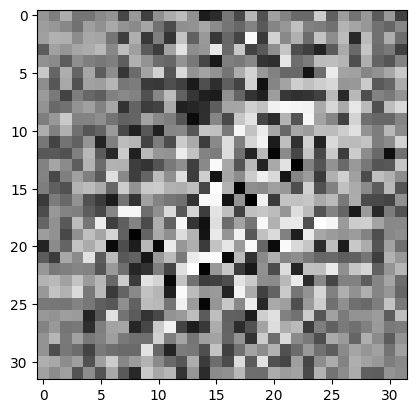

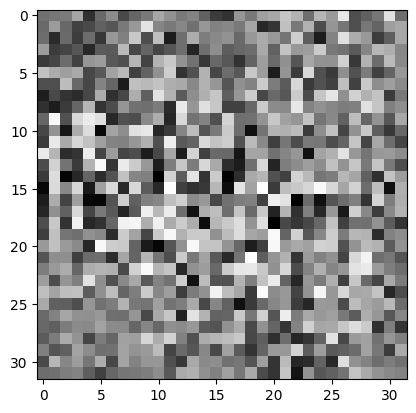

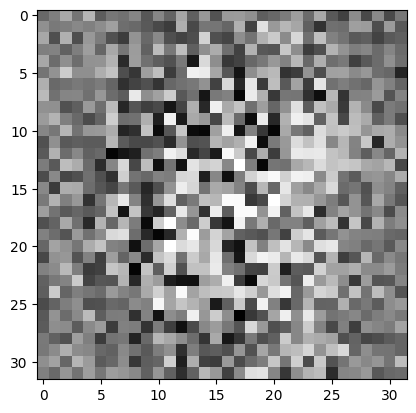

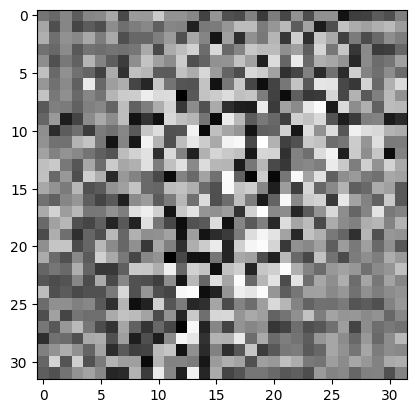

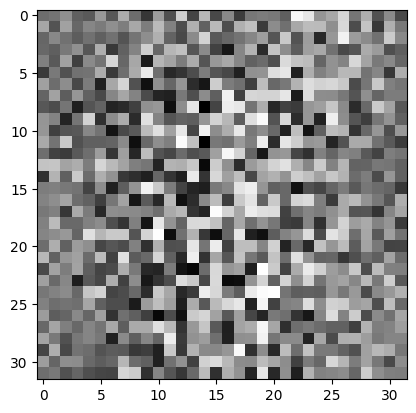

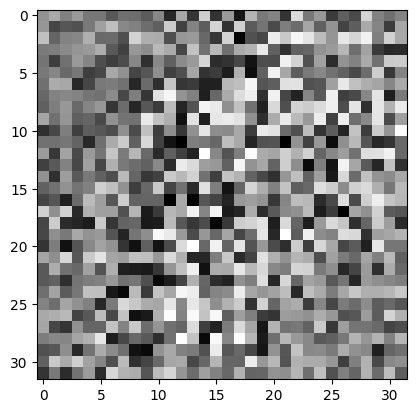

Saving models with cycle loss: 7.4115


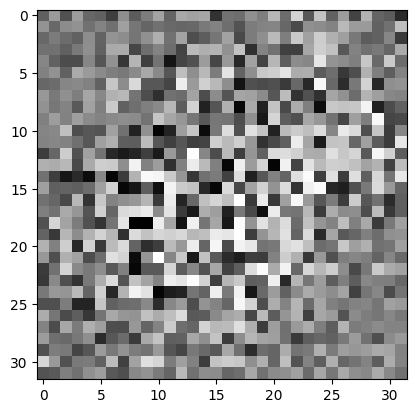

Epoch [20/200], Step [0/50], G_loss: 11.9780, G_identity: 3.9565, G_GAN: 0.5522, G_cycle: 7.4693, D_A_loss: 0.8734, D_B_loss: 0.2425


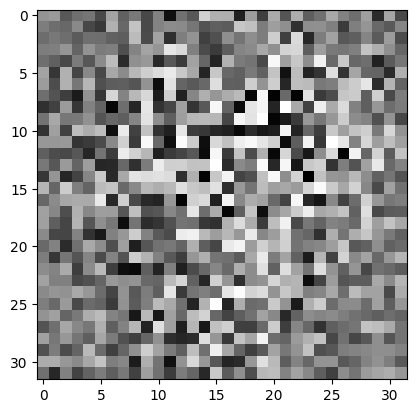

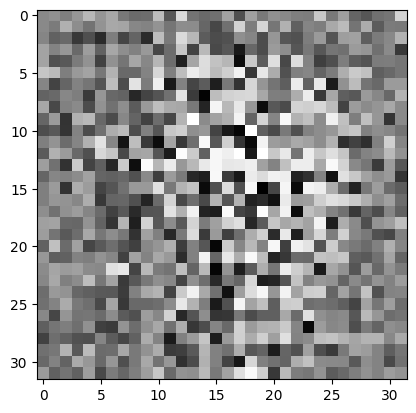

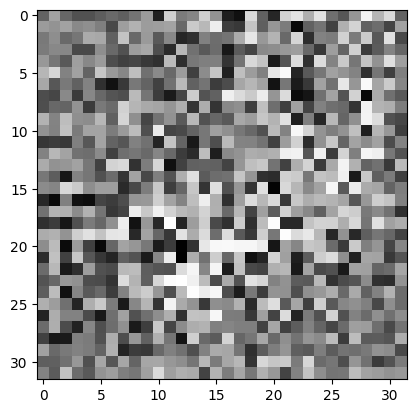

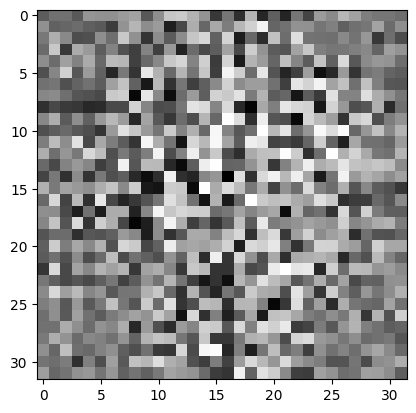

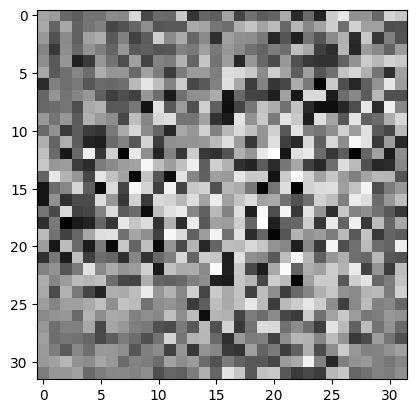

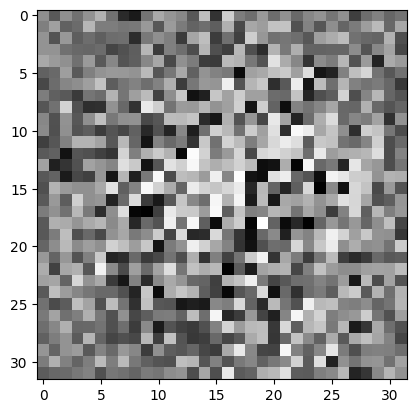

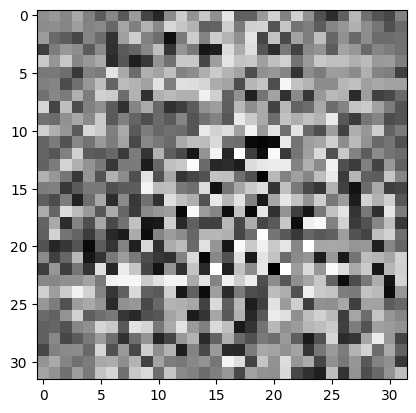

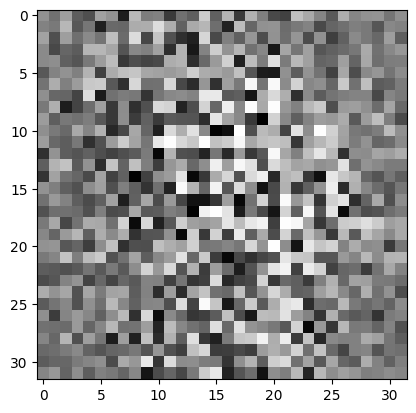

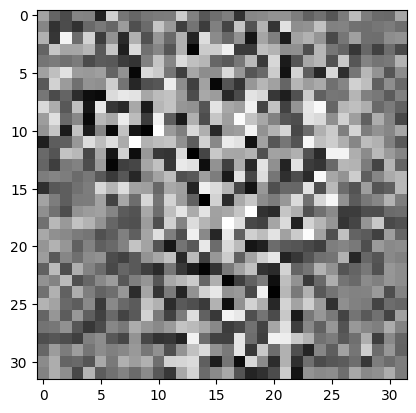

Saving models with cycle loss: 7.3973


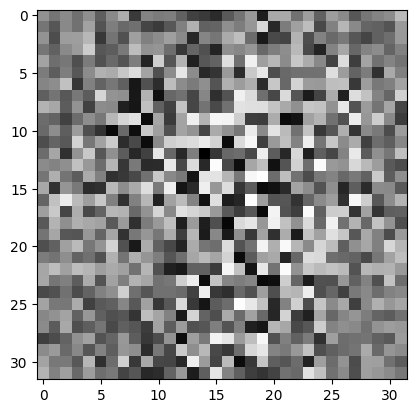

Epoch [21/200], Step [0/50], G_loss: 11.8560, G_identity: 3.9680, G_GAN: 0.5254, G_cycle: 7.3625, D_A_loss: 0.8295, D_B_loss: 0.2486


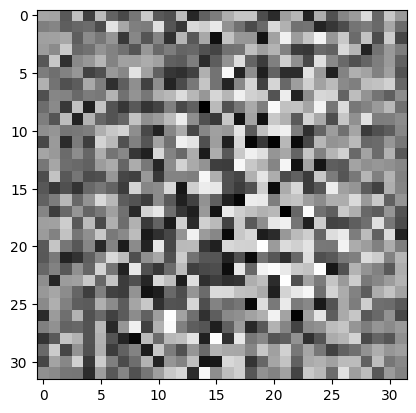

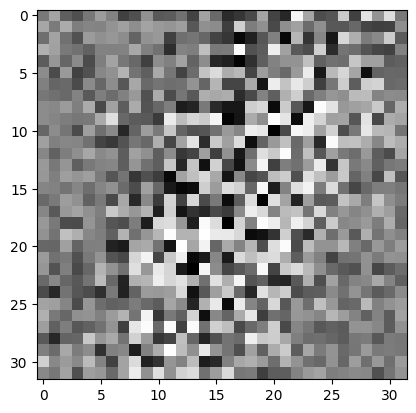

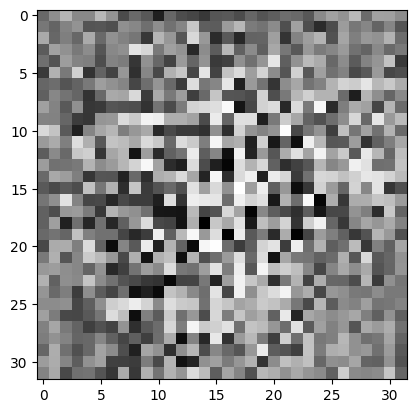

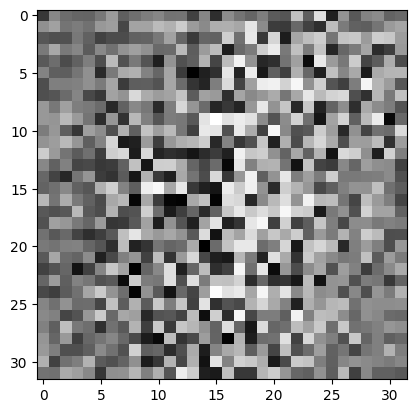

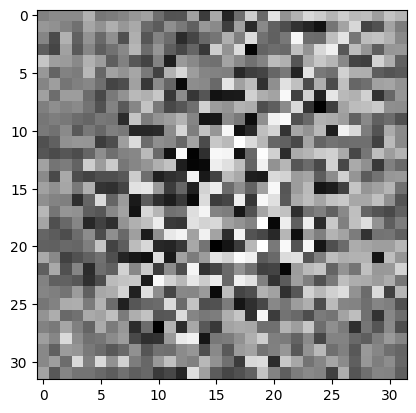

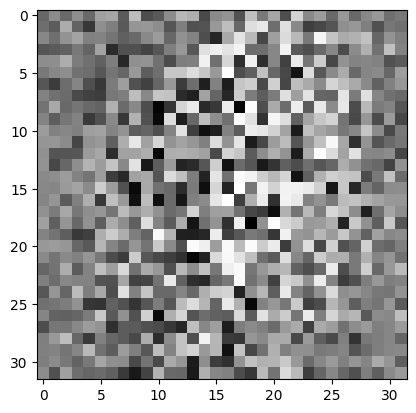

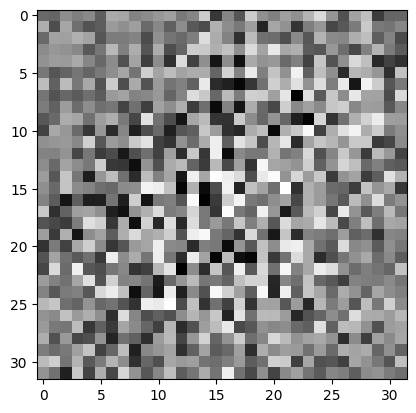

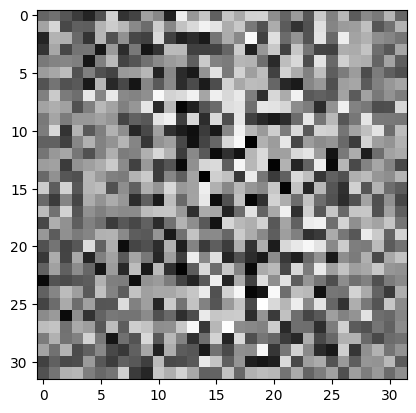

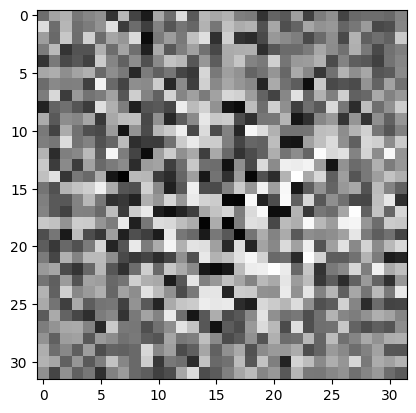

Saving models with cycle loss: 7.3724


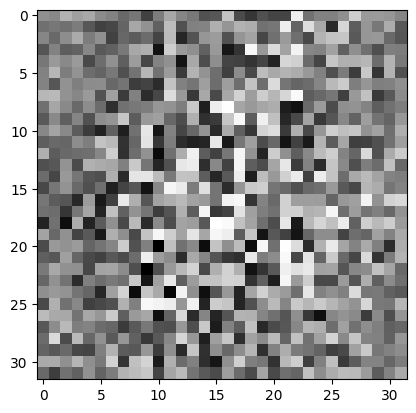

Epoch [22/200], Step [0/50], G_loss: 12.0217, G_identity: 4.0022, G_GAN: 0.5838, G_cycle: 7.4358, D_A_loss: 0.8566, D_B_loss: 0.2221


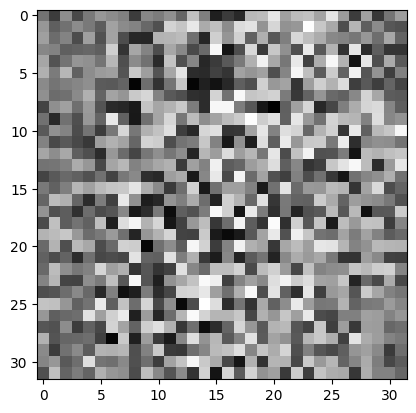

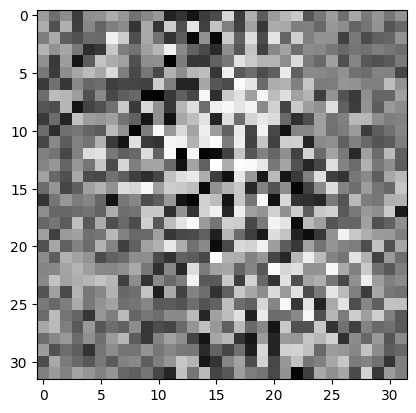

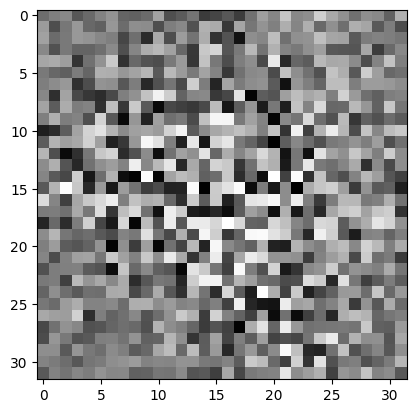

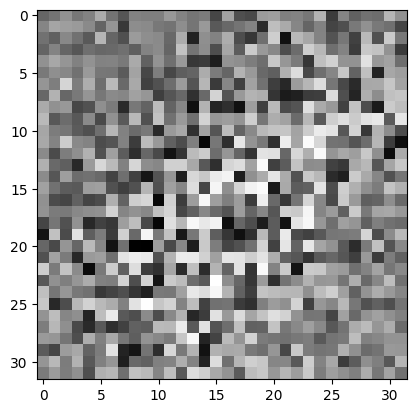

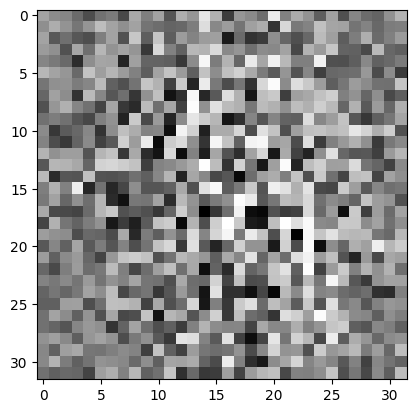

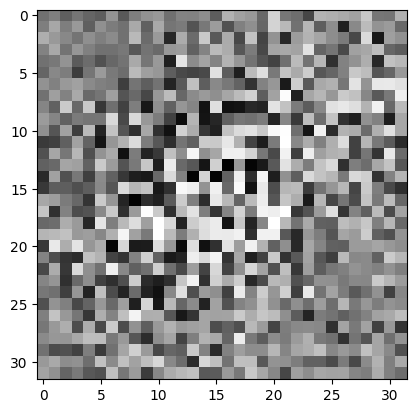

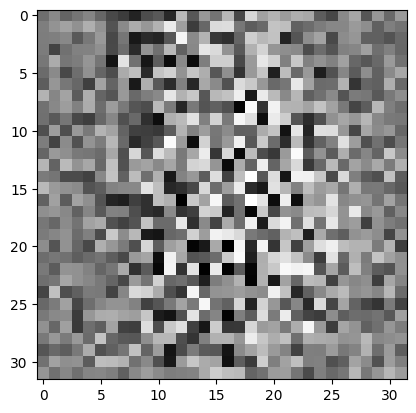

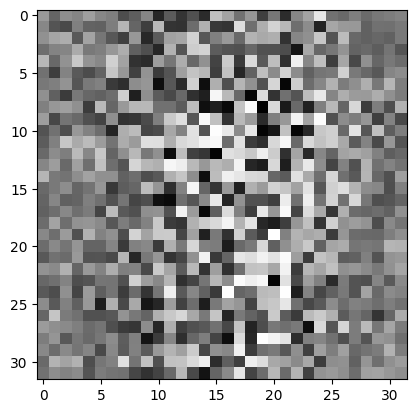

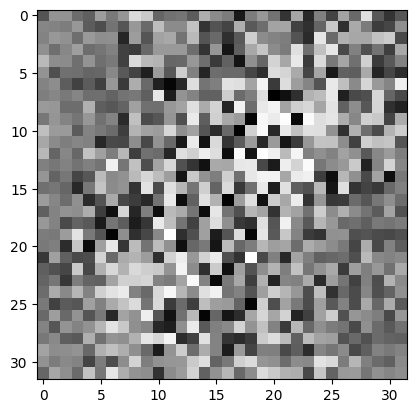

Saving models with cycle loss: 7.3663


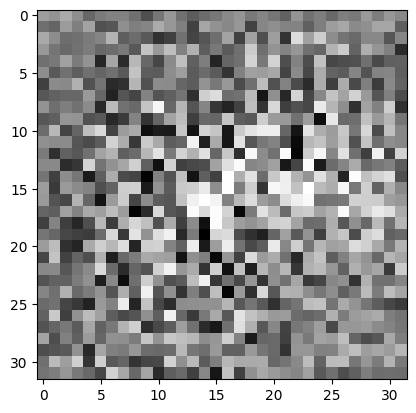

Epoch [23/200], Step [0/50], G_loss: 11.8502, G_identity: 3.9887, G_GAN: 0.5666, G_cycle: 7.2949, D_A_loss: 0.8363, D_B_loss: 0.2062


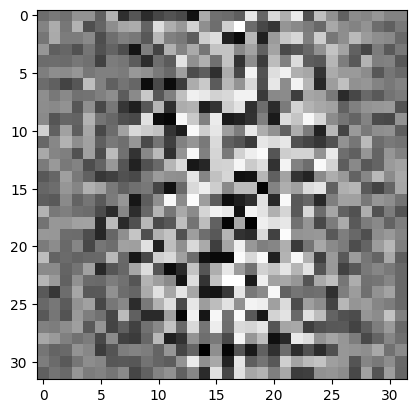

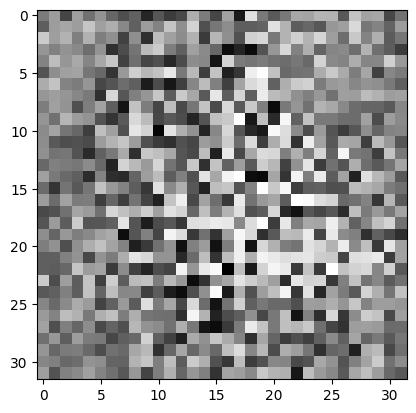

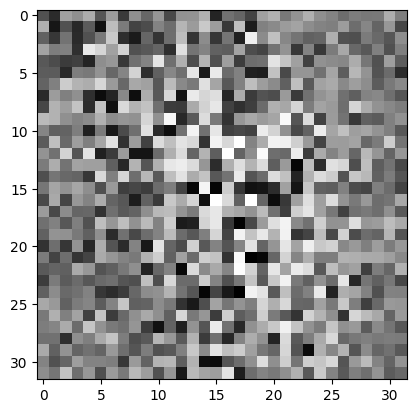

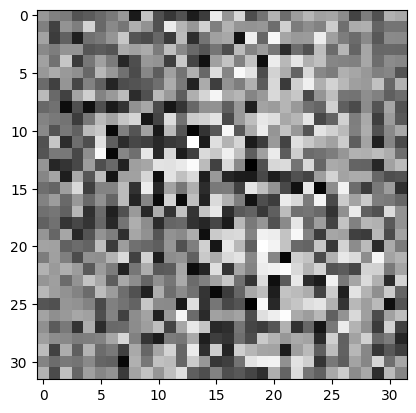

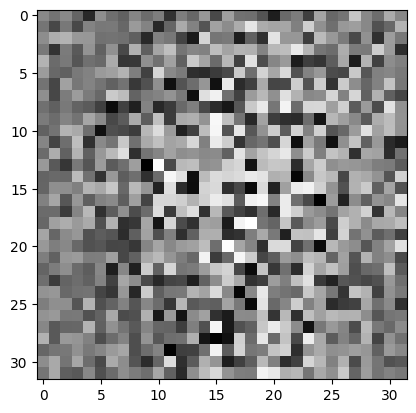

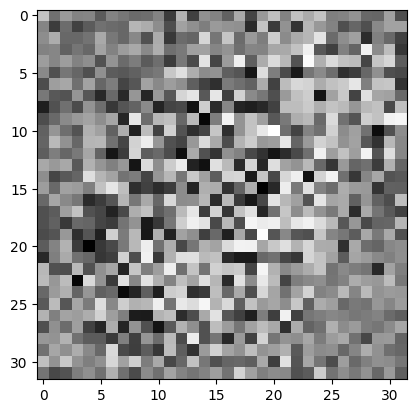

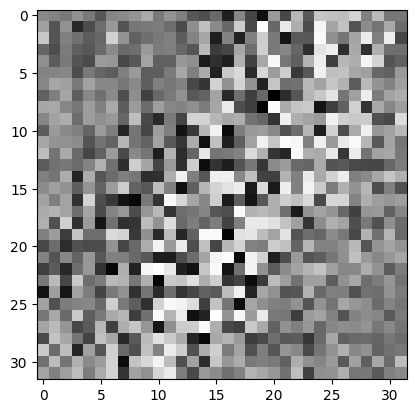

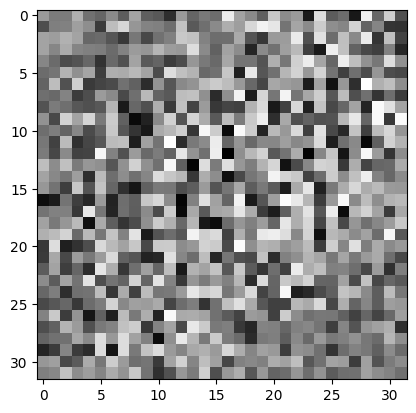

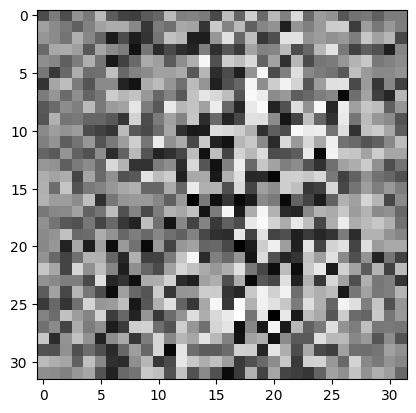

Saving models with cycle loss: 7.3499


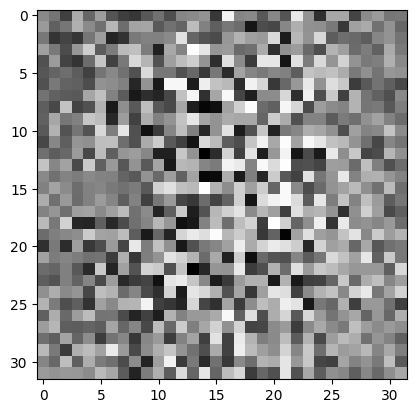

Epoch [24/200], Step [0/50], G_loss: 11.7363, G_identity: 3.9398, G_GAN: 0.5121, G_cycle: 7.2844, D_A_loss: 0.8486, D_B_loss: 0.2331


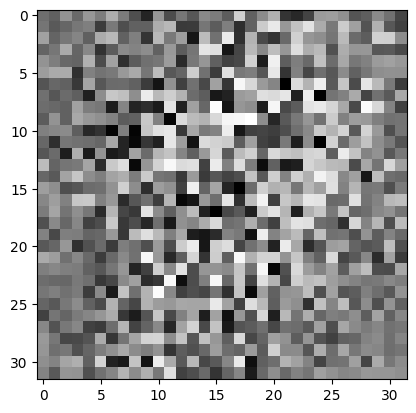

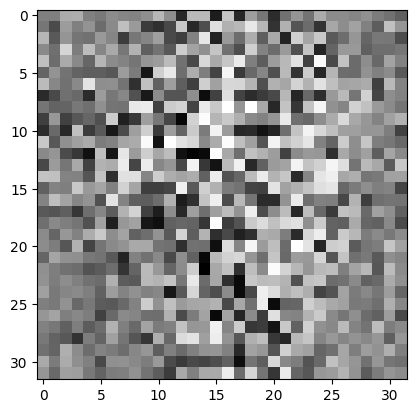

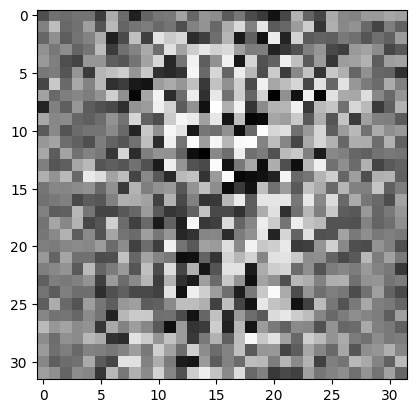

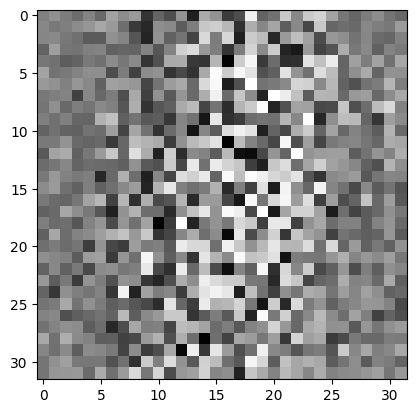

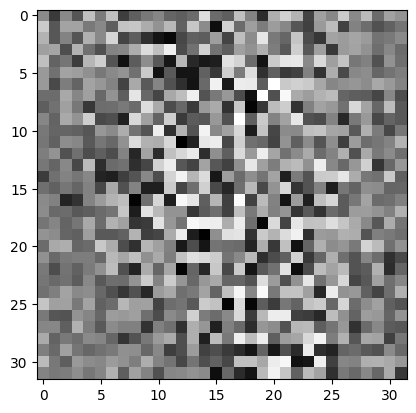

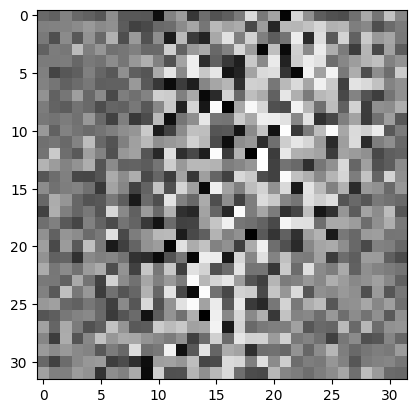

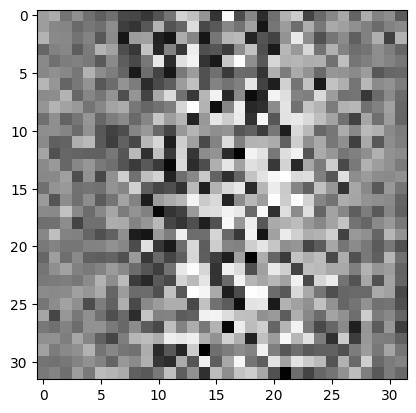

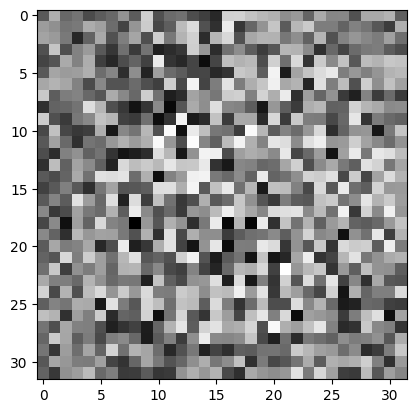

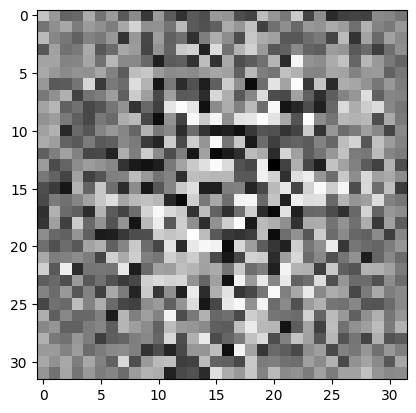

Saving models with cycle loss: 7.3483


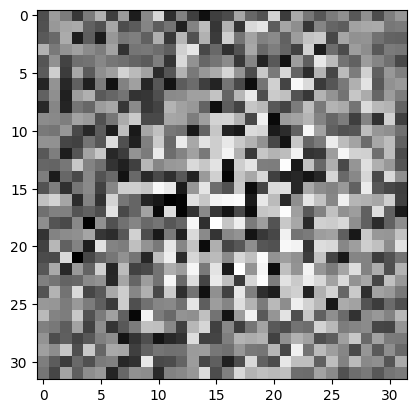

Epoch [25/200], Step [0/50], G_loss: 11.9795, G_identity: 4.0063, G_GAN: 0.5250, G_cycle: 7.4482, D_A_loss: 0.8552, D_B_loss: 0.2203


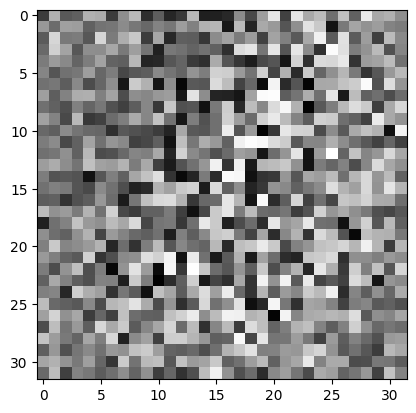

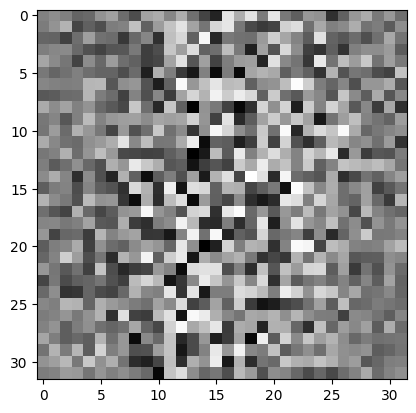

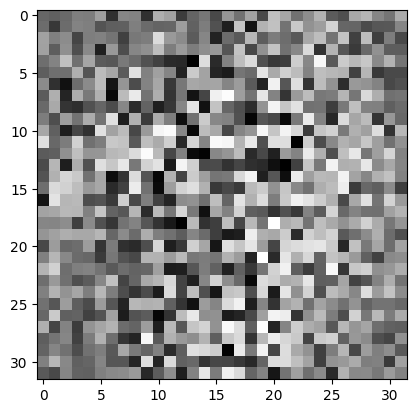

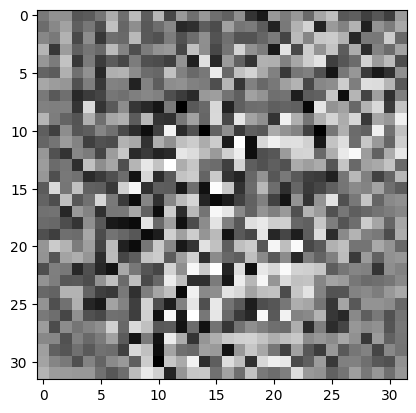

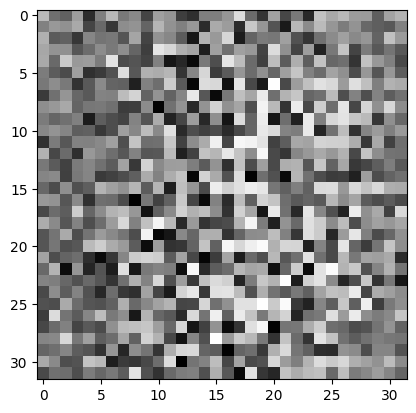

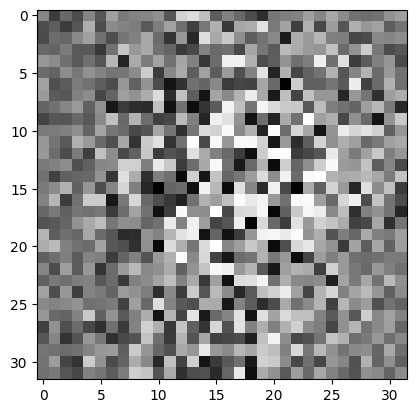

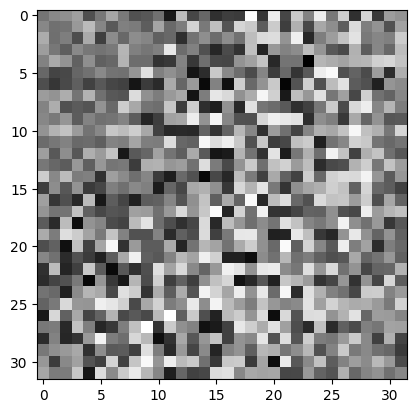

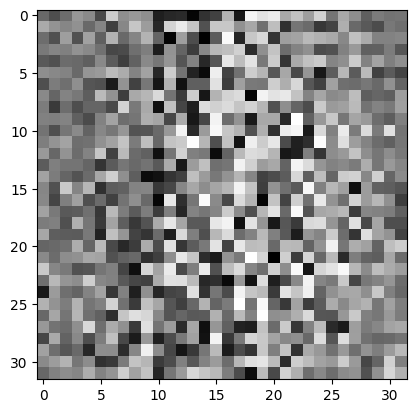

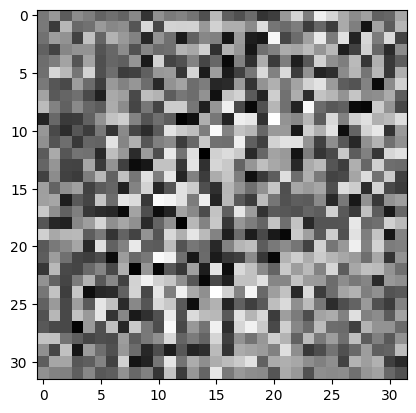

Saving models with cycle loss: 7.3406


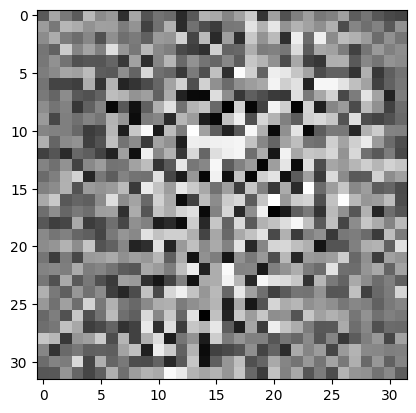

Epoch [26/200], Step [0/50], G_loss: 11.8175, G_identity: 3.9424, G_GAN: 0.4904, G_cycle: 7.3847, D_A_loss: 0.8497, D_B_loss: 0.2222


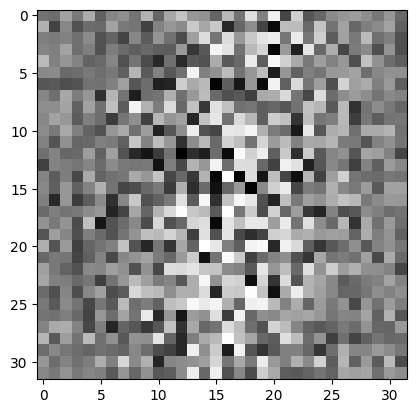

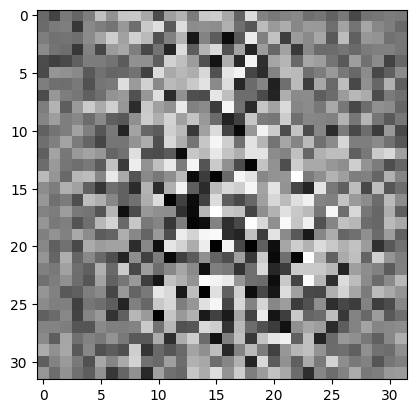

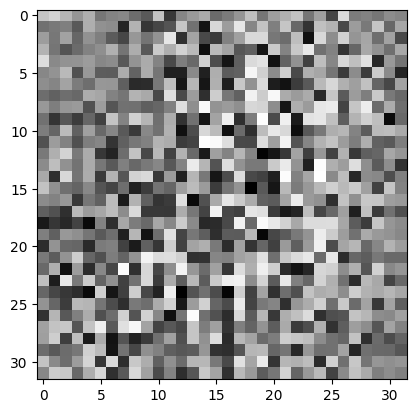

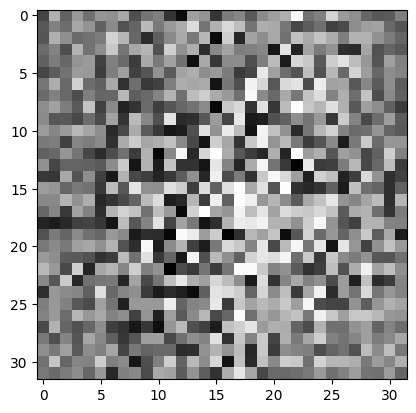

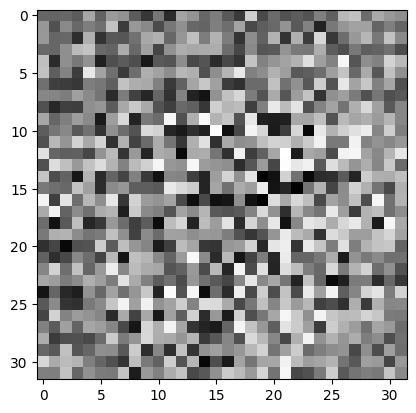

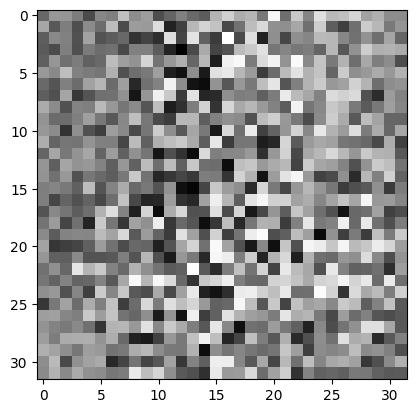

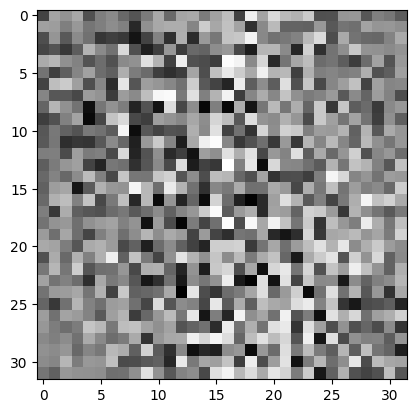

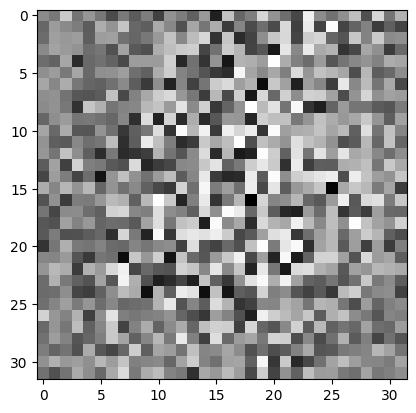

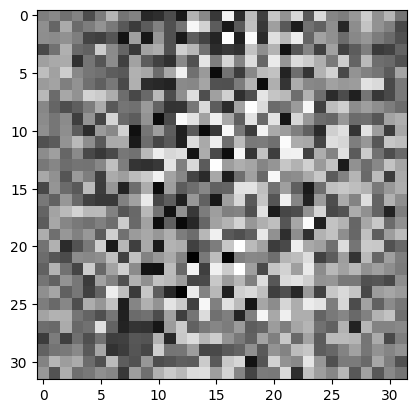

Saving models with cycle loss: 7.3343


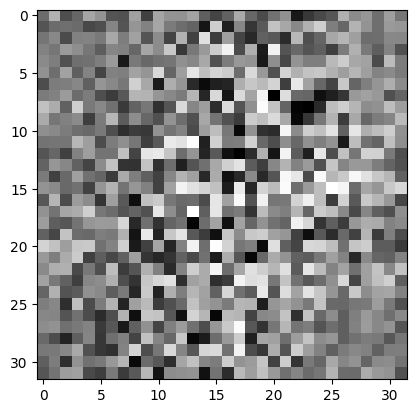

Epoch [27/200], Step [0/50], G_loss: 12.1260, G_identity: 4.0606, G_GAN: 0.5274, G_cycle: 7.5381, D_A_loss: 0.8551, D_B_loss: 0.2012


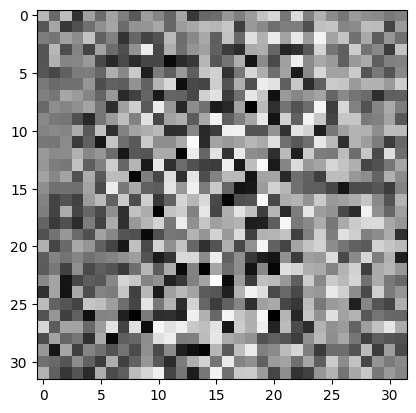

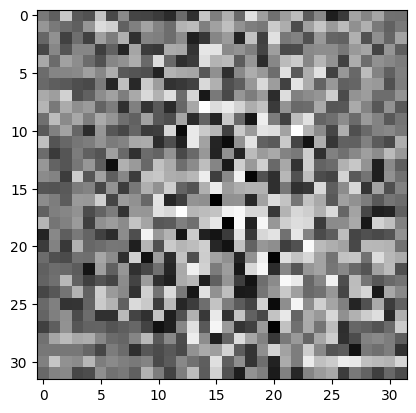

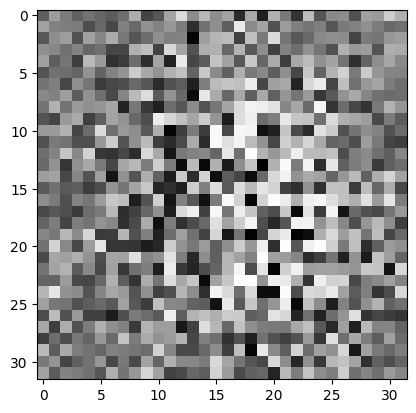

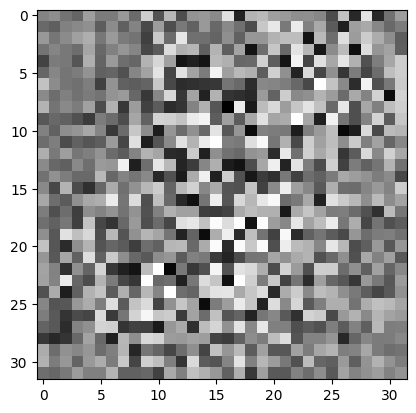

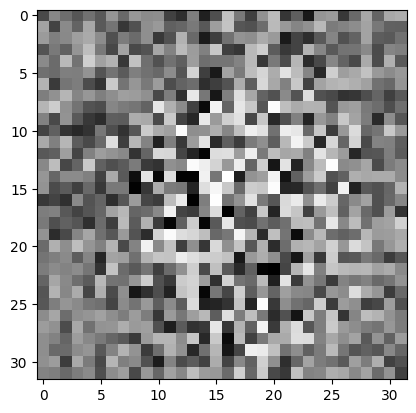

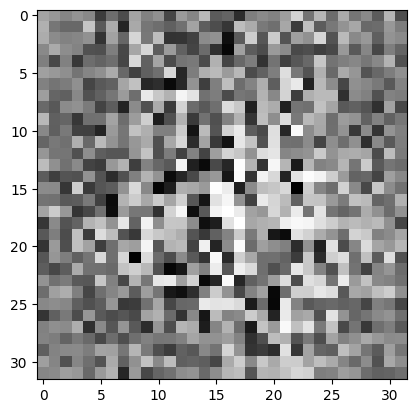

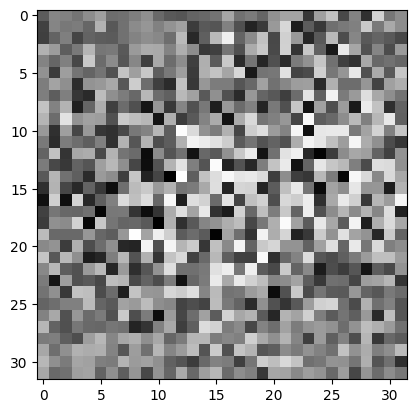

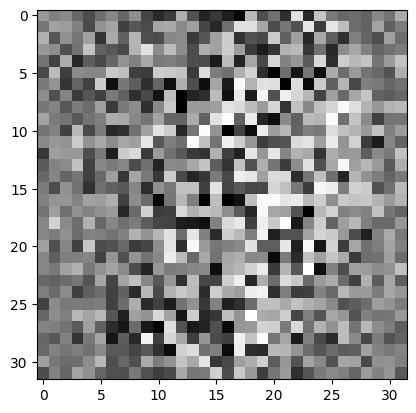

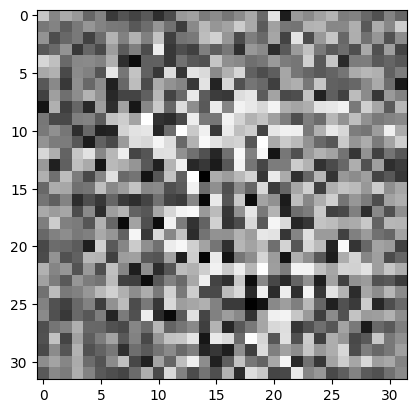

Saving models with cycle loss: 7.3071


In [ ]:
import random

# Define a simple buffer to store previously generated fake images
class ImagePool:
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        self.num_imgs = 0
        self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images

        return_images = []
        for image in images:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.images.append(image)
                self.num_imgs += 1
                return_images.append(image)
            else:
                if random.uniform(0, 1) > 0.5:
                    idx = random.randint(0, self.pool_size - 1)
                    tmp = self.images[idx].clone()
                    self.images[idx] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)

        return_images = torch.cat(return_images, 0)
        return return_images

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor
input_A = torch.empty(params['batch_size'], params['channels'], params['img_dim'], params['img_dim'], device=device, dtype=torch.float32)
input_B = torch.empty(params['batch_size'], params['channels'], params['img_dim'], params['img_dim'], device=device, dtype=torch.float32)
target_real = torch.full((params['batch_size'], 1), 1.0, device=device, dtype=torch.float32, requires_grad=False)
target_fake = torch.full((params['batch_size'], 1), 0.0, device=device, dtype=torch.float32, requires_grad=False)



# Define training function
def train_cycle_gan(n_epochs, source_loader, target_loader):
    #  Initialize losses lists
    D_A_losses = []
    D_B_losses = []
    G_identity_losses = []
    G_GAN_losses = []
    G_cycle_losses = []

    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize fake image pools
    fake_A_pool = ImagePool()
    fake_B_pool = ImagePool()

    best_cycle_loss = float('inf')
    best_G_loss = float('inf')

    # Training loop
    for epoch in range(n_epochs):
        epoch_D_A_losses = []
        epoch_D_B_losses = []
        epoch_G_identity_losses = []
        epoch_G_GAN_losses = []
        epoch_G_cycle_losses = []


        for i, (source_batch, target_batch) in enumerate(zip_longest(source_loader, target_loader)):

            real_A = Variable(source_batch[0].to(device))
            real_B = Variable(target_batch[0].to(device))

            ###### Generators A2B and B2A ######
            G_optimizer.zero_grad()

            same_B = G_A2B(real_B)
            loss_identity_B = criterion_identity(same_B, real_B)*5.0
            # G_B2A(A) should equal A if real A is fed
            same_A = G_B2A(real_A)
            loss_identity_A = criterion_identity(same_A, real_A)*5.0

            # GAN loss
            fake_B = G_A2B(real_A)
            pred_fake = D_B(fake_B)
            loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

            fake_A = G_B2A(real_B)
            pred_fake = D_A(fake_A)
            loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

            # Cycle loss
            recovered_A = G_B2A(fake_B)
            loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

            recovered_B = G_A2B(fake_A)
            loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

            # Total loss
            loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
            loss_G.backward()

            G_optimizer.step()

            #########################################

            ###### Discriminator A ######
            D_A_optimizer.zero_grad()

            # Real loss
            pred_real = D_A(real_A)
            loss_D_real = criterion_GAN(pred_real, target_real)

            # Fake loss
            fake_A = fake_A_pool.query(fake_A)
            pred_fake = D_A(fake_A.detach())
            loss_D_fake = criterion_GAN(pred_fake, target_fake)

            # Total loss
            loss_D_A = (loss_D_real + loss_D_fake)*0.5
            loss_D_A.backward()

            D_A_optimizer.step()

            ###################################

            ###### Discriminator B ######
            D_B_optimizer.zero_grad()

            # Real loss
            pred_real = D_B(real_B)
            loss_D_real = criterion_GAN(pred_real, target_real)

            # Fake loss
            fake_B = fake_B_pool.query(fake_B)
            pred_fake = D_B(fake_B.detach())
            loss_D_fake = criterion_GAN(pred_fake, target_fake)

            # Total loss
            loss_D_B = (loss_D_real + loss_D_fake)*0.5
            loss_D_B.backward()

            D_B_optimizer.step()

            ###################################

            # Record losses for this step
            epoch_D_A_losses.append(loss_D_A.item())
            epoch_D_B_losses.append(loss_D_B.item())
            epoch_G_identity_losses.append((loss_identity_A + loss_identity_B).item())
            epoch_G_GAN_losses.append((loss_GAN_A2B + loss_GAN_B2A).item())
            epoch_G_cycle_losses.append((loss_cycle_ABA + loss_cycle_BAB).item())

            if i % 5 == 0:
              plt.imshow(fake_A[0][0].detach().cpu().numpy(),cmap='gray')
              plt.imshow(fake_B[0][0].detach().cpu().numpy(),cmap='gray')
              plt.show()
            # Print losses every 100 steps
            if i % 100 == 0:
                print(f'Epoch [{epoch + 1}/{n_epochs}], Step [{i}/{len(source_loader)}], '
                      f'G_loss: {loss_G.item():.4f}, '
                      f'G_identity: {(loss_identity_A + loss_identity_B).item():.4f}, '
                      f'G_GAN: {(loss_GAN_A2B + loss_GAN_B2A).item():.4f}, '
                      f'G_cycle: {(loss_cycle_ABA + loss_cycle_BAB).item():.4f}, '
                      f'D_A_loss: {loss_D_A.item():.4f}, '
                      f'D_B_loss: {loss_D_B.item():.4f}')

        # Update learning rates
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()

        # Calculate average losses for the epoch
        D_A_avg_loss = np.mean(epoch_D_A_losses)
        D_B_avg_loss = np.mean(epoch_D_B_losses)
        G_identity_avg_loss = np.mean(epoch_G_identity_losses)
        G_GAN_avg_loss = np.mean(epoch_G_GAN_losses)
        G_cycle_avg_loss = np.mean(epoch_G_cycle_losses)

        # Append average losses to lists
        D_A_losses.append(D_A_avg_loss)
        D_B_losses.append(D_B_avg_loss)
        G_identity_losses.append(G_identity_avg_loss)
        G_GAN_losses.append(G_GAN_avg_loss)
        G_cycle_losses.append(G_cycle_avg_loss)

        # # Print average losses for the epoch
        # print(f'Epoch [{epoch + 1}/{n_epochs}], '
        #       f'Avg D_A_loss: {D_A_avg_loss:.4f}, '
        #       f'Avg D_B_loss: {D_B_avg_loss:.4f}, '
        #       f'Avg G_loss: {G_avg_loss:.4f}, '
        #       f'Avg cycle_loss: {cycle_avg_loss:.4f}')

       # Check if the current cycle loss is the best
        if G_cycle_avg_loss < best_cycle_loss:
            best_cycle_loss = G_cycle_avg_loss
            print(f'Saving models with cycle loss: {best_cycle_loss:.4f}')
            torch.save(G_A2B.state_dict(), 'model_checkpoints/cycleGAN/best_G_A2B.pth')
            torch.save(G_B2A.state_dict(), 'model_checkpoints/cycleGAN/best_G_B2A.pth')
    epochs = np.arange(1, n_epochs + 1)

    plt.figure(figsize=(16, 12))

    plt.subplot(3, 2, 1)
    plt.plot(epochs, D_A_losses)
    plt.title('Discriminator A Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(3, 2, 2)
    plt.plot(epochs, D_B_losses)
    plt.title('Discriminator B Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(3, 2, 3)
    plt.plot(epochs, G_identity_losses)
    plt.title('Generator Identity Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(3, 2, 4)
    plt.plot(epochs, G_GAN_losses)
    plt.title('Generator GAN Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(3, 2, 5)
    plt.plot(epochs, G_cycle_losses)
    plt.title('Generator Cycle Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

    return G_A2B, G_B2A

# Call the training function
G_A2B, G_B2A = train_cycle_gan(n_epochs=params['epochs'],
                               source_loader=mnist_trainloader,
                               target_loader=usps_trainloader)


In [ ]:
def load_best_models(G_A2B, G_Β2Α, device):
    G_A2B.load_state_dict(torch.load('model_checkpoints/cycleGAN/best_G_A2B.pth'))
    G_A2B.load_state_dict(torch.load('model_checkpoints/cycleGAN/best_G_B2A.pth'))
    G_A2B.to(device)
    G_B2A.to(device)
    G_A2B.eval()
    G_B2A.eval()
    return G_A2B, G_B2A

def generate_and_plot_images(generator, data_loader, device, num_images=10):
    generator.eval()  # Set the generator to evaluation mode

    fig, axes = plt.subplots(2, num_images, figsize=(20, 5))

    for i, (images, _) in enumerate(data_loader):
        if i >= num_images:
            break

        # Transform A images to look like SVHN
        images = images.to(device)
        transformed_images = generator(images)

        # Original A image (expand to 3 channels if needed)
        mnist_img = images[0][0].cpu().detach().numpy()
        # if mnist_img.shape[0] == 1:
        #     mnist_img = np.repeat(mnist_img, 3, axis=0)

        axes[0, i].imshow(mnist_img, cmap='gray')
        axes[0, i].axis('off')

        # Transformed image
        transformed_img = transformed_images[0][0].cpu().detach().numpy() # (C, H, W) -> (H, W, C)

        axes[1, i].imshow(transformed_img,cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_title('Original A Images')
    axes[1, 0].set_title('Transformed to B')

    plt.show()



# # Load the best models
G_A2B, G_B2A = load_best_models(G_A2B, G_B2A, device)

# Generate and plot transformed images using the MNIST test dataset
generate_and_plot_images(G_A2B, mnist_testloader, device)


In [ ]:
from torchvision.utils import save_image
import os
def transform_and_save_images(generator, data_loader, output_dir):
    """
    Transforms images using the provided generator and saves them into class-specific folders.

    Args:
    - generator (torch.nn.Module): The generator model to transform images.
    - data_loader (torch.utils.data.DataLoader): DataLoader for the dataset to transform.
    - output_dir (str): Directory to save the transformed images.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Ensure output directories for each class exist
    for i in range(10):  # Assuming 10 classes for MNIST
        os.makedirs(os.path.join(output_dir, str(i)), exist_ok=True)

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):

            images = images.to(device)

            labels = labels.to(device)

            # Transform images
            transformed_images = generator(images)

            # Save each image
            for img, label in zip(transformed_images, labels):

                # Create the file path
                class_folder = os.path.join(output_dir, str(label.item()))
                file_path = os.path.join(class_folder, f"{i}_{label.item()}.png")

                # Save the image
                save_image(img, file_path)

            if i % 100 == 0:
                print(f"Processed {i} batches")


In [ ]:
output_directory = 'transformed_mnist_train'

# Transform and save images
transform_and_save_images(G_A2B, mnist_trainloader, output_directory)

### Simple CNN training

In [ ]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Use a dummy input to determine the size of the flattened features
        dummy_input = torch.randn(1, 3, 32, 32)  # Change the input size if necessary
        dummy_output = self.feature_extractor(dummy_input)
        flattened_size = dummy_output.view(-1).size(0)

        # Now use the calculated flattened size for the classifier
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        output = self.classifier(features)
        return output

class DomainDiscriminator(nn.Module):
    def __init__(self, feature_size):
        super(DomainDiscriminator, self).__init__()
        self.domain_classifier = nn.Sequential(
            nn.Linear(feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, 2)  # Two classes: source and target
        )

    def forward(self, x):
        output = self.domain_classifier(x)
        return output

# Initialize the model and print the flattened feature size
model = SimpleCNN()
print(model)


In [ ]:
feature_extractor = SimpleCNN().to(params['device'])
flattened_size = feature_extractor.classifier[0].in_features  # Get the input feature size of the first Linear layer
domain_discriminator = DomainDiscriminator(flattened_size).to(params['device'])

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(feature_extractor.parameters()) + list(domain_discriminator.parameters()), lr=0.00001)


In [ ]:
def train(model, domain_model, source_loader, target_loader, criterion, optimizer, num_epochs=10):
    model.train()
    domain_model.train()

    for epoch in range(num_epochs):
        for (source_data, source_labels), (target_data, _) in zip(source_loader, target_loader):
            source_data, source_labels = source_data.to(params['device']), source_labels.to(params['device'])
            target_data = target_data.to(params['device'])

            # Train feature extractor and classifier on source data
            optimizer.zero_grad()
            source_features = model.feature_extractor(source_data)
            source_output = model.classifier(source_features.view(source_features.size(0), -1))
            source_loss = criterion(source_output, source_labels)
            source_loss.backward()
            optimizer.step()

            # Train domain discriminator on source and target data
            optimizer.zero_grad()
            domain_labels = torch.cat((torch.zeros(source_data.size(0)), torch.ones(target_data.size(0)))).long().to(params['device'])
            combined_data = torch.cat((source_data, target_data))
            combined_features = model.feature_extractor(combined_data)
            domain_output = domain_model(combined_features.view(combined_features.size(0), -1))
            domain_loss = criterion(domain_output, domain_labels)
            domain_loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Source Loss: {source_loss.item():.4f}, Domain Loss: {domain_loss.item():.4f}')

# Train the model
train(feature_extractor, domain_discriminator, transformed_dataloader, svhn_trainloader, criterion, optimizer)


In [ ]:
def evaluate(model, loader, device):

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in loader:
            data, labels = data.to(params['device']), labels.to(params['device'])
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

source_accuracy = evaluate(feature_extractor, mnist_testloader, params['device'])
target_accuracy = evaluate(feature_extractor, svhn_testloader, params['device'])
print(f'Source (MNIST) Accuracy: {source_accuracy:.2f}%')
print(f'Target (SVHN) Accuracy: {target_accuracy:.2f}%')


### Best Results So far

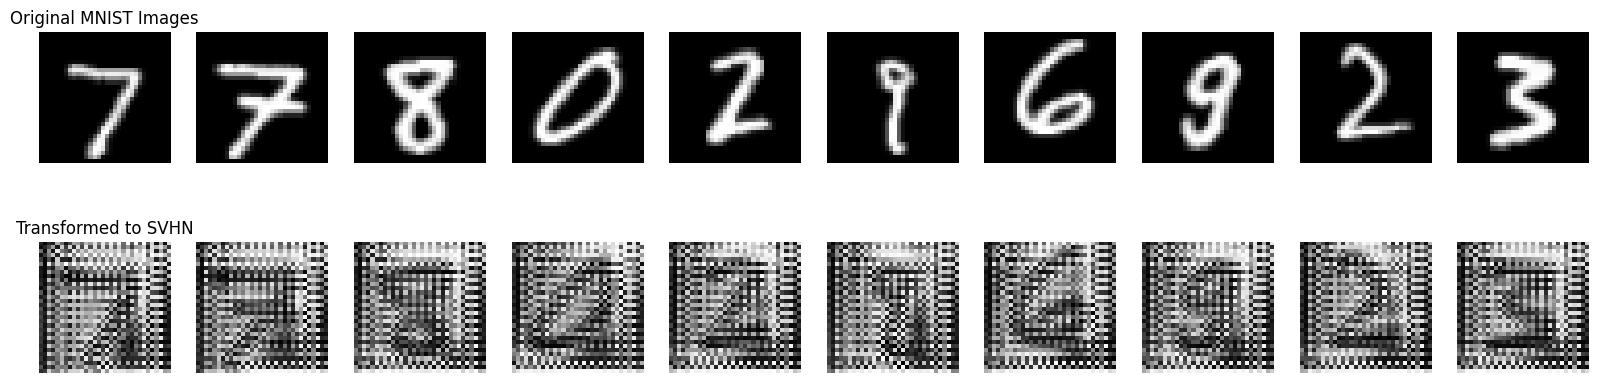

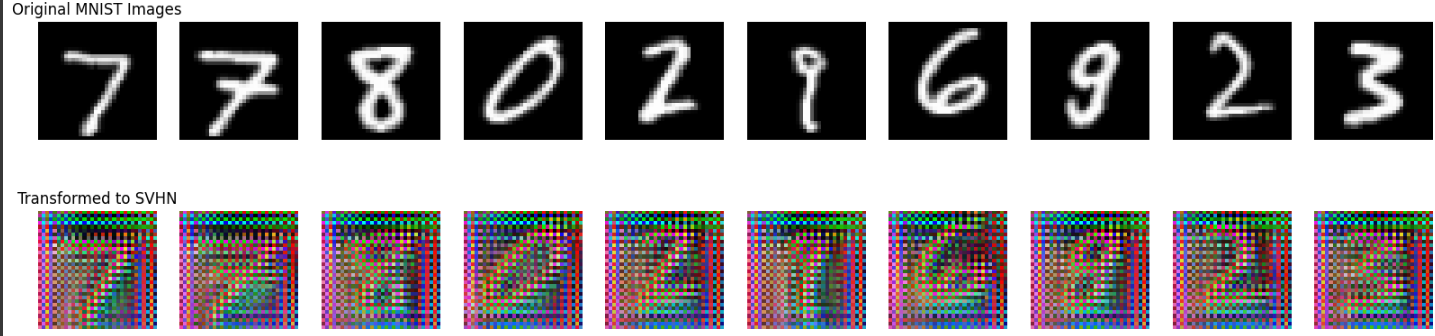

#### Best Result architexture:

In [ ]:
#https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/models.py
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.LeakyReLU(0.2, inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.Dropout(0.5),
                    nn.LeakyReLU(0.2, inplace=True) ]

        # Downsampling (only one downsampling step for 32x32)
        in_features = 64
        out_features = in_features * 2
        model += [nn.AvgPool2d(1),
                  nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                  nn.InstanceNorm2d(out_features),
                  nn.Dropout(0.5),
                  nn.LeakyReLU(0.2, inplace=True)]
        in_features = out_features

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling (only one upsampling step for 32x32)
        out_features = in_features // 2
        model += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(out_features),
                  nn.Dropout(0.5),
                  nn.LeakyReLU(0.2, inplace=True)]
        in_features = out_features

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        model = [nn.Conv2d(input_nc, 64, 4, stride=2, padding=1), # Ouput: 16x16
                 nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(64, 128, 4, stride=2, padding=1), # Ouput: 8x18
                  nn.InstanceNorm2d(128),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(128, 256, 4, stride=2, padding=1), # Ouput: 4x4
                  nn.InstanceNorm2d(256),
                  nn.LeakyReLU(0.2, inplace=True)]

        # model += [nn.Conv2d(256, 512, 4, padding=1), # Ouput: 3x3
        #           nn.InstanceNorm2d(512),
        #           nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(256, 1, 4, padding=1)]  # Output: 2x2 (final output)

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

    def output_shape(self, input_shape):
        x = torch.zeros(1, *input_shape).to(device)
        x = self.model(x)
        return x.size()